In [1]:
# @title
import os

# Set Kaggle username and API token
os.environ["KAGGLE_USERNAME"] = "sairamreddykorimilla"
os.environ["KAGGLE_KEY"] = ""#Kagglekey


In [ ]:
# @title
#libraried installation and data downloads
!kaggle competitions download -c ieee-fraud-detection
!unzip ieee-fraud-detection.zip -d /content/dataset-folder
#!pip install polars -#Already installed for Colab

100% 118M/118M [00:06<00:00, 23.9MB/s]
100% 118M/118M [00:06<00:00, 18.9MB/s]
Archive:  ieee-fraud-detection.zip
  inflating: /content/dataset-folder/sample_submission.csv  
  inflating: /content/dataset-folder/test_identity.csv  
  inflating: /content/dataset-folder/test_transaction.csv  
  inflating: /content/dataset-folder/train_identity.csv  
  inflating: /content/dataset-folder/train_transaction.csv  


In [ ]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import warnings

In [ ]:
# Constants
NUM_COLUMNS = 150
CHUNK_SIZE = 100000  # Define an appropriate chunk size

# Load Data Efficiently
def load_large_csv(file_path, chunk_size=CHUNK_SIZE):
    dfs = [chunk for chunk in pd.read_csv(file_path, chunksize=chunk_size)]
    return pd.concat(dfs, ignore_index=True)

# Load datasets
train_data = load_large_csv('/content/dataset-folder/train_transaction.csv')
test_data = load_large_csv('/content/dataset-folder/test_transaction.csv')
train_identity = load_large_csv('/content/dataset-folder/train_identity.csv')
test_identity = load_large_csv('/content/dataset-folder/test_identity.csv')

In [ ]:
# Display dataset information
print(f'Train data shape: {train_data.shape}, Identity data shape: {train_identity.shape}')
print(f'Test data shape: {test_data.shape}, Identity data shape: {test_identity.shape}')
print("Preview of train data:")
print(train_data.head(10))

Train data shape: (590540, 394), Identity data shape: (144233, 41)
Test data shape: (506691, 393), Identity data shape: (141907, 41)
Preview of train data:
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399 

In [ ]:
# Select relevant columns
selected_columns = train_data.columns[:NUM_COLUMNS].tolist()
key_columns = {'TransactionID', 'card1', 'addr1', 'C1', 'D1', 'M1', 'V1'}

In [ ]:
# Function to visualize trends over time
def plot_time_series(feature):
    limit = 8000 if feature == 'TransactionAmt' else np.inf
    plt.figure(figsize=(15, 3))
    plt.plot(train_data[train_data['isFraud'] == 0]['TransactionDT'],
             train_data[train_data['isFraud'] == 0][feature].clip(0, limit), '.', label='No Fraud')
    plt.plot(train_data[train_data['isFraud'] == 1]['TransactionDT'],
             train_data[train_data['isFraud'] == 1][feature].clip(0, limit), '.', label='Fraud')
    plt.plot(test_data['TransactionDT'], test_data[feature].clip(0, limit), '.', label='Test Data')
    plt.legend()
    plt.title(f'Distribution of {feature} Over Time')
    plt.show()

# Function to generate summary statistics
def summarize_data(dataset, feature, label):
    summary = dataset[feature].describe().reset_index()
    summary.columns = [feature, label]
    additional_stats = pd.DataFrame({
        feature: ['Unique values', 'Missing values', 'Missing %'],
        label: [dataset[feature].nunique(), dataset[feature].isnull().sum(), round(dataset[feature].isnull().mean(), 4)]
    })
    return pd.concat([summary, additional_stats], ignore_index=True)

# Function to display detailed information about a column
def feature_analysis(column):
    reports = [
        summarize_data(train_data, column, 'Train'),
        summarize_data(train_data[train_data['isFraud'] == 1], column, 'Fraud Cases'),
        summarize_data(train_data[train_data['isFraud'] == 0], column, 'Non-Fraud Cases'),
        summarize_data(test_data, column, 'Test Data')
    ]

    num_public = int(test_data.shape[0] * 0.2)
    reports.append(summarize_data(test_data.iloc[:num_public], column, 'Public Test'))
    reports.append(summarize_data(test_data.iloc[num_public:], column, 'Private Test'))

    full_report = pd.concat(reports, axis=1)
    print(full_report)

    if column != 'TransactionID':
        print(f'Most common values for {column} (NaN replaced with -999):')
        filled_train = train_data[['isFraud', column]].fillna(-999)
        filled_test = test_data[['TransactionID', column]].fillna(-999)

        common_values = filled_train.groupby(column)['isFraud'].agg(['count', 'mean', 'sum']).reset_index()
        test_counts = filled_test.groupby(column)['TransactionID'].count().reset_index()

        merged_summary = common_values.merge(test_counts, how='left', on=column).nlargest(10, 'count')
        print(merged_summary)

        print(f'Highest fraud-related values for {column} (NaN replaced with -999):')
        high_fraud_values = common_values.nlargest(10, 'sum').merge(test_counts, how='left', on=column)
        print(high_fraud_values)

# Function to plot feature distribution
def plot_histogram(feature):
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    axes[0].hist(train_data[feature].dropna(), bins=70)
    axes[0].set_title(f'Train Data: {feature}')
    axes[1].hist(test_data[feature].dropna(), bins=70)
    axes[1].set_title(f'Test Data: {feature}')
    plt.show()

# Function to compute correlation with a specific column
def compute_correlation(target_feature):
    numeric_features = train_data.select_dtypes(include=[np.number]).columns.tolist()
    correlations = train_data[numeric_features].corrwith(train_data[target_feature]).dropna().reset_index()
    correlations.columns = ['Feature', f'Correlation with {target_feature}']
    correlations = correlations.sort_values(by=f'Correlation with {target_feature}', ascending=False)

    print(f'Top correlated features with {target_feature}:')
    print(pd.concat([correlations.head(6), correlations.tail(5)]))

# Function to analyze a column
def evaluate_column(column_name):
    if column_name not in {'isFraud', 'TransactionDT'}:
        print(f'Analyzing feature: {column_name}')
        if train_data[column_name].dtype == 'object':
            feature_analysis(column_name)
        else:
            plot_time_series(column_name)
            plot_histogram(column_name)
            feature_analysis(column_name)
            compute_correlation(column_name)


Analyzing feature: TransactionID


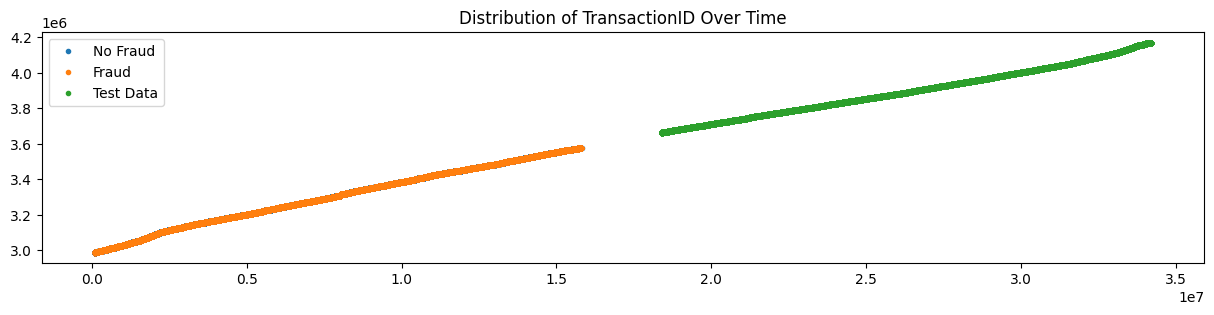

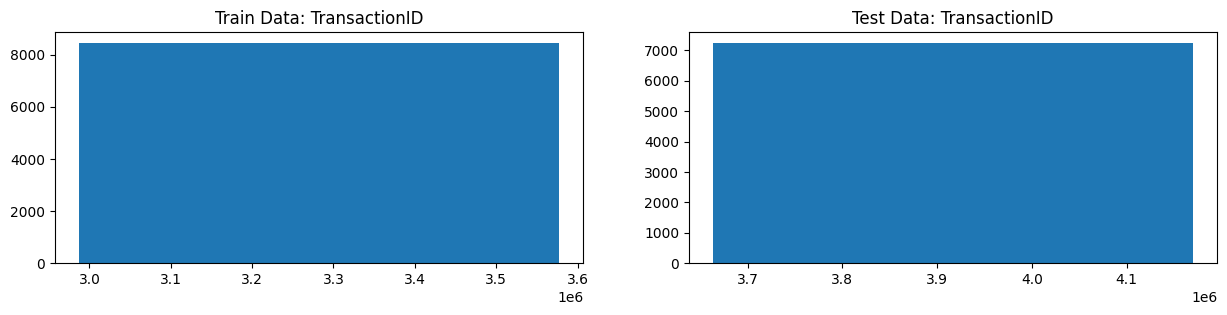

     TransactionID         Train   TransactionID   Fraud Cases  \
0            count  5.905400e+05           count  2.066300e+04   
1             mean  3.282270e+06            mean  3.294952e+06   
2              std  1.704744e+05             std  1.620403e+05   
3              min  2.987000e+06             min  2.987203e+06   
4              25%  3.134635e+06             25%  3.167366e+06   
5              50%  3.282270e+06             50%  3.291934e+06   
6              75%  3.429904e+06             75%  3.428646e+06   
7              max  3.577539e+06             max  3.577526e+06   
8    Unique values  5.905400e+05   Unique values  2.066300e+04   
9   Missing values  0.000000e+00  Missing values  0.000000e+00   
10       Missing %  0.000000e+00       Missing %  0.000000e+00   

     TransactionID  Non-Fraud Cases   TransactionID     Test Data  \
0            count     5.698770e+05           count  5.066910e+05   
1             mean     3.281810e+06            mean  3.916894e+06   


In [ ]:
# Analyze each selected column
for feature in selected_columns:
    evaluate_column(feature)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   
5  555.0  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
6  360.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
7  490.0  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
8  100.0  150.0        visa  226.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   
9  111.0  150.0  mastercard  224.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  
5  NaN   NaN   NaN   NaN  
6  NaN   NaN   NaN   NaN  
7  NaN   NaN   NaN   NaN  
8  0.0   0.0   0.0   0.0  
9  NaN   NaN   NaN   NaN  

[10 rows x 394 columns]

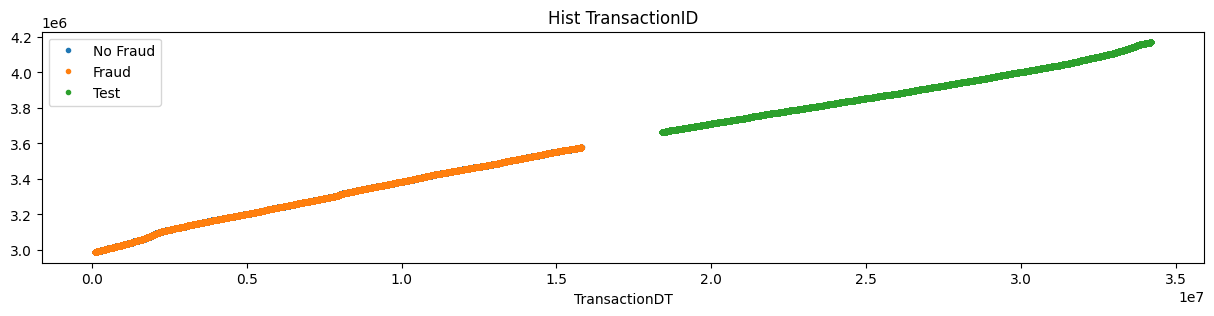

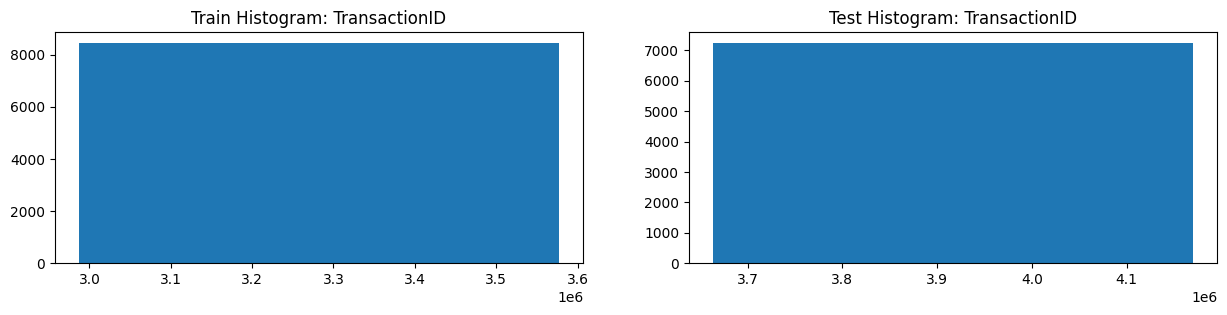

TransactionID         Train  TransactionID   Train Fraud  TransactionID  \
0           count  5.905400e+05          count  2.066300e+04          count   
1            mean  3.282270e+06           mean  3.294952e+06           mean   
2             std  1.704744e+05            std  1.620403e+05            std   
3             min  2.987000e+06            min  2.987203e+06            min   
4             25%  3.134635e+06            25%  3.167366e+06            25%   
5             50%  3.282270e+06            50%  3.291934e+06            50%   
6             75%  3.429904e+06            75%  3.428646e+06            75%   
7             max  3.577539e+06            max  3.577526e+06            max   
8   unique values  5.905400e+05  unique values  2.066300e+04  unique values   
9            NaNs  0.000000e+00           NaNs  0.000000e+00           NaNs   
10     NaNs share  0.000000e+00     NaNs share  0.000000e+00     NaNs share   

    Train Not Fraud  TransactionID          Test  TransactionID   Test Public  \
0      5.698770e+05          count  5.066910e+05          count  1.013380e+05   
1      3.281810e+06           mean  3.916894e+06           mean  3.714218e+06   
2      1.707548e+05            std  1.462692e+05            std  2.925391e+04   
3      2.987000e+06            min  3.663549e+06            min  3.663549e+06   
4      3.133317e+06            25%  3.790222e+06            25%  3.688883e+06   
5      3.281808e+06            50%  3.916894e+06            50%  3.714218e+06   
6      3.429974e+06            75%  4.043566e+06            75%  3.739552e+06   
7      3.577539e+06            max  4.170239e+06            max  3.764886e+06   
8      5.698770e+05  unique values  5.066910e+05  unique values  1.013380e+05   
9      0.000000e+00           NaNs  0.000000e+00           NaNs  0.000000e+00   
10     0.000000e+00     NaNs share  0.000000e+00     NaNs share  0.000000e+00   

    TransactionID  Test Private  
0           count  4.053530e+05  
1            mean  3.967563e+06  
2             std  1.170155e+05  
3             min  3.764887e+06  
4             25%  3.866225e+06  
5             50%  3.967563e+06  
6             75%  4.068901e+06  
7             max  4.170239e+06  
8   unique values  4.053530e+05  
9            NaNs  0.000000e+00  
10     NaNs share  0.000000e+00

Column  Correlation with TransactionID
0    TransactionID                        1.000000
2    TransactionDT                        0.998280
366           V326                        0.251746
370           V330                        0.250831
369           V329                        0.244867
367           V327                        0.242576
185           V145                       -0.273548
200           V160                       -0.282572
199           V159                       -0.302742
191           V151                       -0.303988
190           V150                       -0.306317

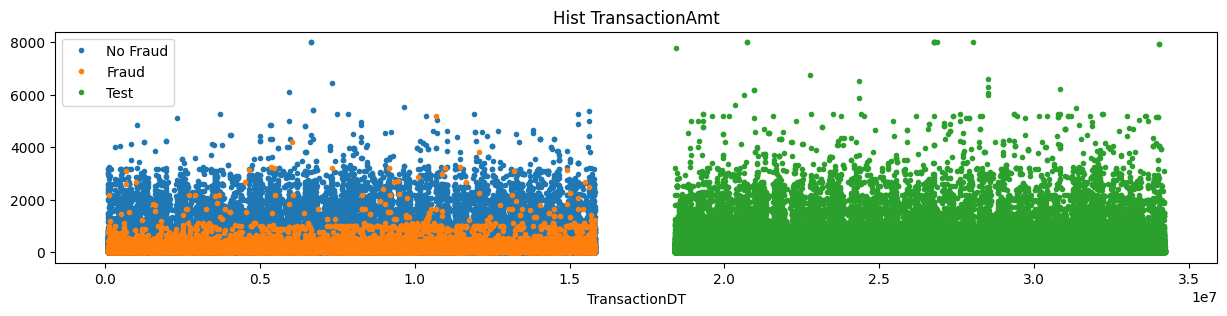

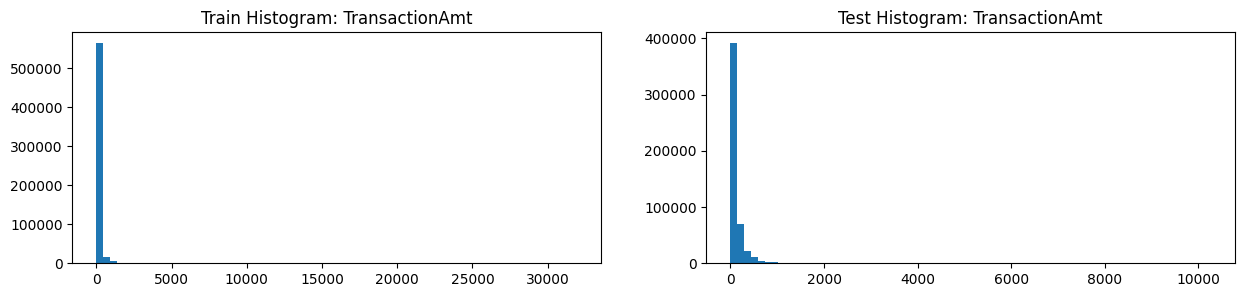

TransactionAmt          Train TransactionAmt   Train Fraud TransactionAmt  \
0           count  590540.000000          count  20663.000000          count   
1            mean     135.027176           mean    149.244779           mean   
2             std     239.162522            std    232.212163            std   
3             min       0.251000            min      0.292000            min   
4             25%      43.321000            25%     35.044000            25%   
5             50%      68.769000            50%     75.000000            50%   
6             75%     125.000000            75%    161.000000            75%   
7             max   31937.391000            max   5191.000000            max   
8   unique values   20902.000000  unique values   2515.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud TransactionAmt           Test TransactionAmt  \
0     569877.000000          count  506691.000000          count   
1        134.511665           mean     134.725568           mean   
2        239.395078            std     245.779822            std   
3          0.251000            min       0.018000            min   
4         43.970000            25%      40.000000            25%   
5         68.500000            50%      67.950000            50%   
6        120.000000            75%     125.000000            75%   
7      31937.391000            max   10270.000000            max   
8      20560.000000  unique values   14119.000000  unique values   
9          0.000000           NaNs       0.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public TransactionAmt   Test Private  
0   101338.000000          count  405353.000000  
1      141.733098           mean     132.973690  
2      257.474940            std     242.736757  
3        0.018000            min       0.140000  
4       45.950000            25%      39.000000  
5       72.950000            50%      67.950000  
6      134.950000            75%     120.950000  
7     9154.460000            max   10270.000000  
8     5144.000000  unique values   12117.000000  
9        0.000000           NaNs       0.000000  
10       0.000000     NaNs share       0.000000

TransactionAmt  Train Count  Mean Fraud  Fraud Count  Test Count
5015            59.00        30582    0.021124          646     27365.0
7921           117.00        28933    0.024851          719     25798.0
7580           107.95        23954    0.009226          221     20243.0
4934            57.95        23600    0.003814           90     20063.0
7253           100.00        20362    0.025685          523     17565.0
4327            50.00        17009    0.020754          353     14469.0
4247            49.00        15990    0.029331          469     14231.0
10185          226.00        11704    0.033322          390     11084.0
3440            39.00        11095    0.021812          242      9926.0
2573            29.00        10683    0.018815          201      9019.0

TransactionAmt   size      mean  sum  TransactionID
0           117.0  28933  0.024851  719          25798
1            59.0  30582  0.021124  646          27365
2           150.0   8356  0.067137  561           7426
3           100.0  20362  0.025685  523          17565
4            49.0  15990  0.029331  469          14231
5           200.0   6590  0.064188  423           6115
6           226.0  11704  0.033322  390          11084
7           300.0   2438  0.145611  355           2104
8            50.0  17009  0.020754  353          14469
9           171.0   7682  0.035407  272           7233

Column  Correlation with TransactionAmt
3    TransactionAmt                         1.000000
179            V139                         0.222308
180            V140                         0.207470
248            V208                         0.198601
201            V161                         0.197351
203            V163                         0.191320
55              V15                        -0.139413
134             V94                        -0.141014
92              V52                        -0.142297
90              V50                        -0.144958
91              V51                        -0.149459

ProductCD   Train      ProductCD Train Fraud      ProductCD  \
0          count  590540          count       20663          count   
1         unique       5         unique           5         unique   
2            top       W            top           W            top   
3           freq  439670           freq        8969           freq   
4  unique values     5.0  unique values         5.0  unique values   
5           NaNs     0.0           NaNs         0.0           NaNs   
6     NaNs share     0.0     NaNs share         0.0     NaNs share   

  Train Not Fraud      ProductCD    Test      ProductCD Test Public  \
0          569877          count  506691          count      101338   
1               5         unique       5         unique           5   
2               W            top       W            top           W   
3          430701           freq  360987           freq       82562   
4             5.0  unique values     5.0  unique values         5.0   
5             0.0           NaNs     0.0           NaNs         0.0   
6             0.0     NaNs share     0.0     NaNs share         0.0   

       ProductCD Test Private  
0          count       405353  
1         unique            5  
2            top            W  
3           freq       278425  
4  unique values          5.0  
5           NaNs          0.0  
6     NaNs share          0.0

ProductCD  Train Count  Mean Fraud  Fraud Count  Test Count
4         W       439670    0.020399         8969      360987
0         C        68519    0.116873         8008       69266
2         R        37699    0.037826         1426       35647
1         H        33024    0.047662         1574       29373
3         S        11628    0.058996          686       11418

ProductCD    size      mean   sum  TransactionID
0         W  439670  0.020399  8969         360987
1         C   68519  0.116873  8008          69266
2         H   33024  0.047662  1574          29373
3         R   37699  0.037826  1426          35647
4         S   11628  0.058996   686          11418

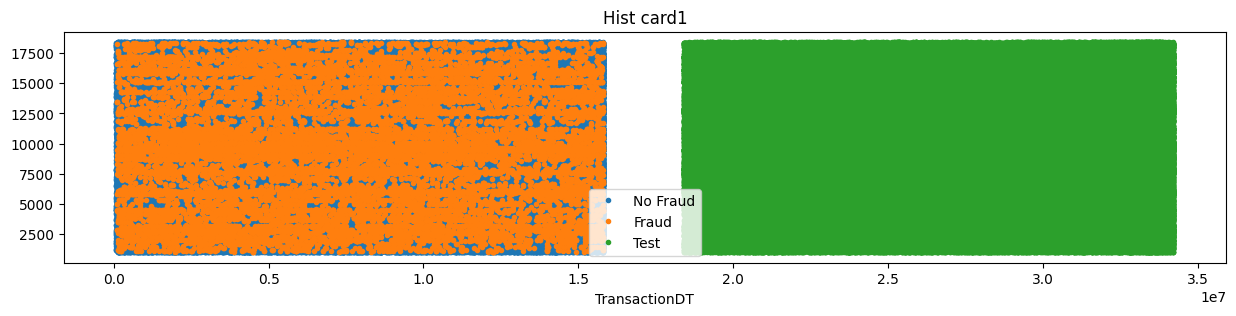

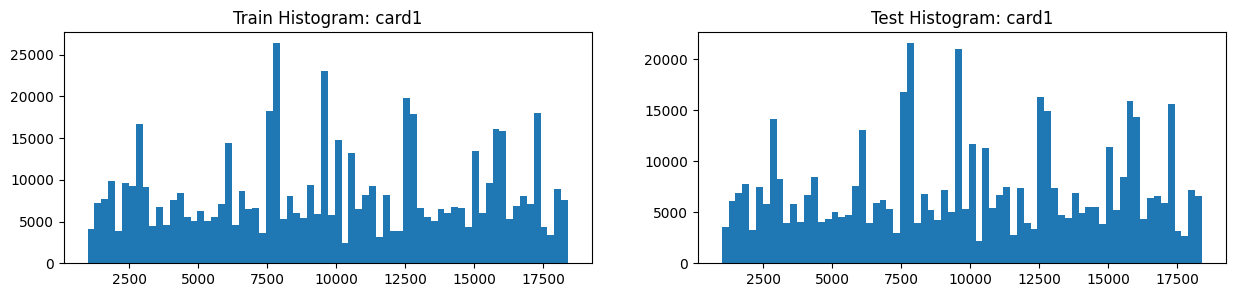

card1          Train          card1   Train Fraud          card1  \
0           count  590540.000000          count  20663.000000          count   
1            mean    9898.734658           mean   9547.654164           mean   
2             std    4901.170153            std   4762.051380            std   
3             min    1000.000000            min   1015.000000            min   
4             25%    6019.000000            25%   5732.500000            25%   
5             50%    9678.000000            50%   9633.000000            50%   
6             75%   14184.000000            75%  13623.000000            75%   
7             max   18396.000000            max  18375.000000            max   
8   unique values   13553.000000  unique values   1740.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud          card1           Test          card1  \
0     569877.000000          count  506691.000000          count   
1       9911.464381           mean    9957.222175           mean   
2       4905.672370            std    4884.960969            std   
3       1000.000000            min    1001.000000            min   
4       6019.000000            25%    6019.000000            25%   
5       9711.000000            50%    9803.000000            50%   
6      14229.000000            75%   14276.000000            75%   
7      18396.000000            max   18397.000000            max   
8      13350.000000  unique values   13244.000000  unique values   
9          0.000000           NaNs       0.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public          card1   Test Private  
0   101338.000000          count  405353.000000  
1     9907.304387           mean    9969.701591  
2     4854.934403            std    4892.365179  
3     1006.000000            min    1001.000000  
4     6053.000000            25%    6019.000000  
5     9653.000000            50%    9803.000000  
6    14052.000000            75%   14290.000000  
7    18396.000000            max   18397.000000  
8     6935.000000  unique values   12300.000000  
9        0.000000           NaNs       0.000000  
10       0.000000     NaNs share       0.000000

card1  Train Count  Mean Fraud  Fraud Count  Test Count
5365    7919        14932    0.007501          112     13083.0
6615    9500        14162    0.037283          528     12081.0
11593  15885        10361    0.042853          444     12330.0
12616  17188        10344    0.026875          278      9262.0
10950  15066         7945    0.039396          313      6661.0
9143   12695         7091    0.028346          201      5641.0
9014   12544         6773    0.021556          146      5921.0
3886    6019         6771    0.043420          294      6497.0
1412    2803         6141    0.011887           73      4902.0
5106    7585         5334    0.049306          263      4763.0

card1   size      mean  sum  TransactionID
0   9633   4158  0.178451  742           4751
1   9500  14162  0.037283  528          12081
2  15885  10361  0.042853  444          12330
3   9026   2076  0.191233  397            894
4  15063   2522  0.126487  319           2060
5   2616   4410  0.071202  314           1786
6   5812   2818  0.111427  314           3879
7  15066   7945  0.039396  313           6661
8   9917    919  0.332971  306            920
9   6019   6771  0.043420  294           6497

Column  Correlation with card1
4    card1                1.000000
370   V330                0.146483
369   V329                0.142539
364   V324                0.138616
373   V333                0.136557
368   V328                0.134419
189   V149               -0.023889
196   V156               -0.024232
38     D13               -0.028603
33      D8               -0.040851
7    card5               -0.093633

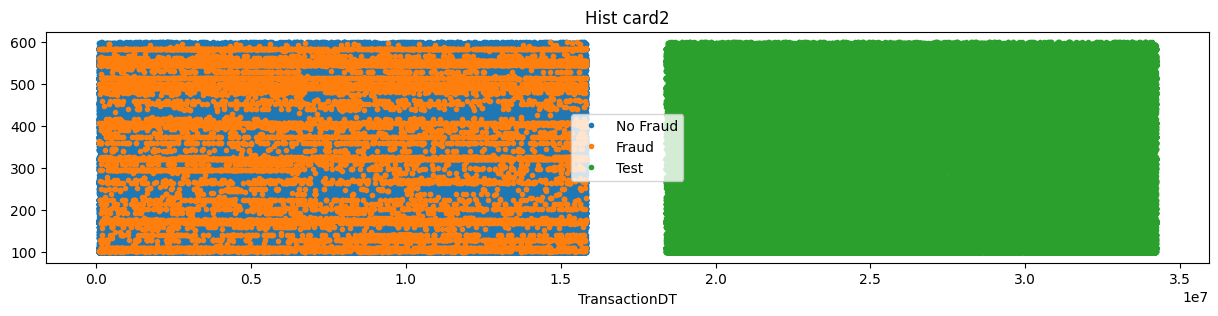

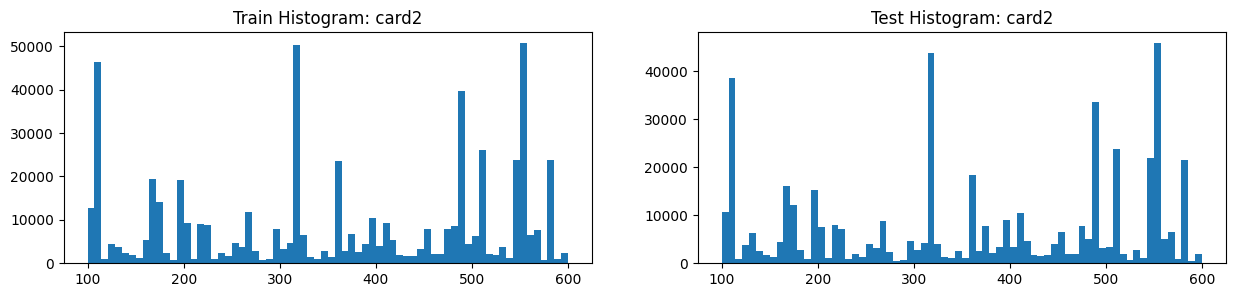

card2          Train          card2   Train Fraud          card2  \
0           count  581607.000000          count  20240.000000          count   
1            mean     362.555488           mean    365.370850           mean   
2             std     157.793246            std    159.623511            std   
3             min     100.000000            min    100.000000            min   
4             25%     214.000000            25%    204.000000            25%   
5             50%     361.000000            50%    375.000000            50%   
6             75%     512.000000            75%    514.000000            75%   
7             max     600.000000            max    600.000000            max   
8   unique values     500.000000  unique values    327.000000  unique values   
9            NaNs    8933.000000           NaNs    423.000000           NaNs   
10     NaNs share       0.015100     NaNs share      0.020500     NaNs share   

    Train Not Fraud          card2           Test          card2  \
0     561367.000000          count  498037.000000          count   
1        362.453981           mean     363.735379           mean   
2        157.726065            std     158.688653            std   
3        100.000000            min     100.000000            min   
4        215.000000            25%     207.000000            25%   
5        361.000000            50%     369.000000            50%   
6        512.000000            75%     512.000000            75%   
7        600.000000            max     600.000000            max   
8        500.000000  unique values     497.000000  unique values   
9       8510.000000           NaNs    8654.000000           NaNs   
10         0.014900     NaNs share       0.017100     NaNs share   

     Test Public          card2   Test Private  
0   99007.000000          count  399030.000000  
1     358.809458           mean     364.957595  
2     157.773606            std     158.891431  
3     100.000000            min     100.000000  
4     204.000000            25%     214.000000  
5     360.000000            50%     375.000000  
6     512.000000            75%     514.000000  
7     600.000000            max     600.000000  
8     496.000000  unique values     496.000000  
9    2331.000000           NaNs    6323.000000  
10      0.023000     NaNs share       0.015600

card2  Train Count  Mean Fraud  Fraud Count  Test Count
221  321.0        48935    0.028528         1396     42796.0
11   111.0        45191    0.021641          978     37346.0
455  555.0        41995    0.022836          959     38409.0
390  490.0        38145    0.024014          916     32351.0
483  583.0        21803    0.041233          899     19700.0
70   170.0        18214    0.031295          570     15197.0
94   194.0        16938    0.007675          130     14573.0
445  545.0        16355    0.086824         1420     15539.0
260  360.0        15190    0.010402          158     11342.0
414  514.0        14541    0.046214          672     12684.0

card2   size      mean   sum  TransactionID
0  545.0  16355  0.086824  1420          15539
1  321.0  48935  0.028528  1396          42796
2  111.0  45191  0.021641   978          37346
3  555.0  41995  0.022836   959          38409
4  490.0  38145  0.024014   916          32351
5  500.0   5045  0.180575   911           2430
6  583.0  21803  0.041233   899          19700
7  408.0   8012  0.083999   673           9148
8  514.0  14541  0.046214   672          12684
9  130.0   2746  0.239257   657           5395

Column  Correlation with card2
5    card2                1.000000
342   V302                0.097911
344   V304                0.096949
343   V303                0.092447
90     V50                0.084508
111    V71                0.081179
76     V36               -0.042237
53     V13               -0.043501
52     V12               -0.043553
93     V53               -0.043736
94     V54               -0.045313

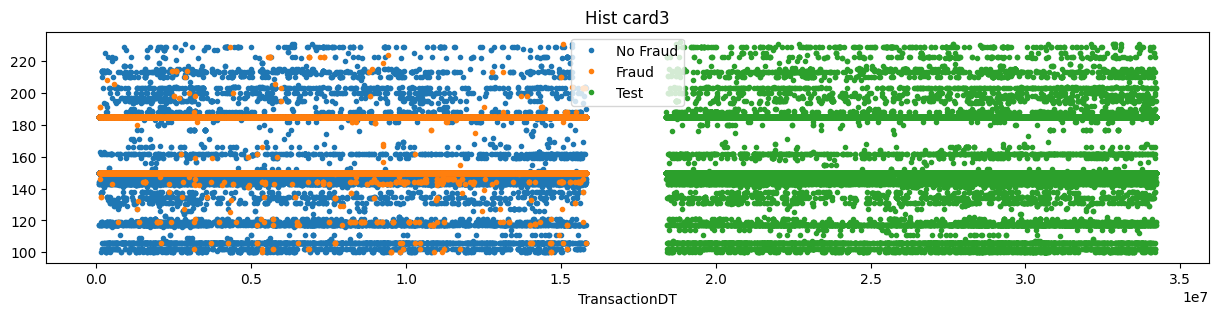

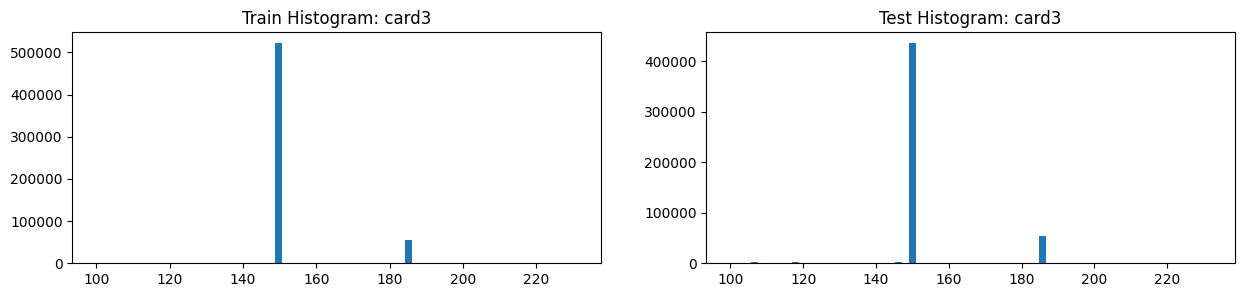

card3          Train          card3   Train Fraud          card3  \
0           count  588975.000000          count  20624.000000          count   
1            mean     153.194925           mean    162.368648           mean   
2             std      11.336444            std     17.495775            std   
3             min     100.000000            min    100.000000            min   
4             25%     150.000000            25%    150.000000            25%   
5             50%     150.000000            50%    150.000000            50%   
6             75%     150.000000            75%    185.000000            75%   
7             max     231.000000            max    231.000000            max   
8   unique values     114.000000  unique values     62.000000  unique values   
9            NaNs    1565.000000           NaNs     39.000000           NaNs   
10     NaNs share       0.002700     NaNs share      0.001900     NaNs share   

    Train Not Fraud          card3           Test          card3  \
0     568351.000000          count  503689.000000          count   
1        152.862034           mean     153.543409           mean   
2         10.904432            std      12.443013            std   
3        100.000000            min     100.000000            min   
4        150.000000            25%     150.000000            25%   
5        150.000000            50%     150.000000            50%   
6        150.000000            75%     150.000000            75%   
7        231.000000            max     232.000000            max   
8        106.000000  unique values     115.000000  unique values   
9       1526.000000           NaNs    3002.000000           NaNs   
10         0.002700     NaNs share       0.005900     NaNs share   

      Test Public          card3   Test Private  
0   100032.000000          count  403657.000000  
1      152.127959           mean     153.894177  
2       10.591973            std      12.836503  
3      100.000000            min     100.000000  
4      150.000000            25%     150.000000  
5      150.000000            50%     150.000000  
6      150.000000            75%     150.000000  
7      232.000000            max     231.000000  
8       74.000000  unique values     110.000000  
9     1306.000000           NaNs    1696.000000  
10       0.012900     NaNs share       0.004200

card3  Train Count  Mean Fraud  Fraud Count  Test Count
43  150.0       521287    0.024568        12807    435558.0
74  185.0        56346    0.130657         7362     53614.0
5   106.0         1571    0.015277           24      1972.0
0  -999.0         1565    0.024920           39      3002.0
38  144.0         1252    0.089457          112      1381.0
39  146.0         1252    0.019968           25      1218.0
12  117.0          962    0.018711           18      1879.0
37  143.0          899    0.031146           28       771.0
14  119.0          750    0.093333           70       341.0
3   102.0          460    0.023913           11       738.0

card3    size      mean    sum  TransactionID
0  150.0  521287  0.024568  12807         435558
1  185.0   56346  0.130657   7362          53614
2  144.0    1252  0.089457    112           1381
3  119.0     750  0.093333     70            341
4 -999.0    1565  0.024920     39           3002
5  143.0     899  0.031146     28            771
6  146.0    1252  0.019968     25           1218
7  106.0    1571  0.015277     24           1972
8  117.0     962  0.018711     18           1879
9  223.0      55  0.254545     14            126

Column  Correlation with card3
6    card3                1.000000
55     V15                0.759508
134    V94                0.758586
56     V16                0.744826
97     V57                0.744299
119    V79                0.738073
93     V53               -0.341900
75     V35               -0.348554
94     V54               -0.351214
76     V36               -0.356215
9    addr2               -0.569108

card4   Train          card4 Train Fraud          card4  \
0          count  588963          count       20622          count   
1         unique       4         unique           4         unique   
2            top    visa            top        visa            top   
3           freq  384767           freq       13373           freq   
4  unique values     4.0  unique values         4.0  unique values   
5           NaNs  1577.0           NaNs        41.0           NaNs   
6     NaNs share  0.0027     NaNs share       0.002     NaNs share   

  Train Not Fraud          card4    Test          card4 Test Public  \
0          568341          count  503605          count       99995   
1               4         unique       4         unique           4   
2            visa            top    visa            top        visa   
3          371394           freq  334882           freq       66077   
4             4.0  unique values     4.0  unique values         4.0   
5          1536.0           NaNs  3086.0           NaNs      1343.0   
6          0.0027     NaNs share  0.0061     NaNs share      0.0133   

           card4 Test Private  
0          count       403610  
1         unique            4  
2            top         visa  
3           freq       268805  
4  unique values          4.0  
5           NaNs       1743.0  
6     NaNs share       0.0043

card4  Train Count  Mean Fraud  Fraud Count  Test Count
4              visa       384767    0.034756        13373      334882
3        mastercard       189217    0.034331         6496      158169
1  american express         8328    0.028698          239        7681
2          discover         6651    0.077282          514        2873
0              -999         1577    0.025999           41        3086

card4    size      mean    sum  TransactionID
0              visa  384767  0.034756  13373         334882
1        mastercard  189217  0.034331   6496         158169
2          discover    6651  0.077282    514           2873
3  american express    8328  0.028698    239           7681
4              -999    1577  0.025999     41           3086

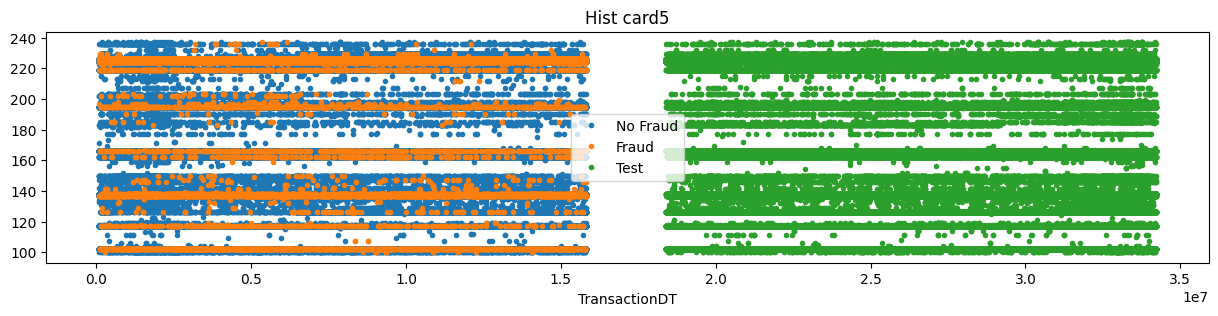

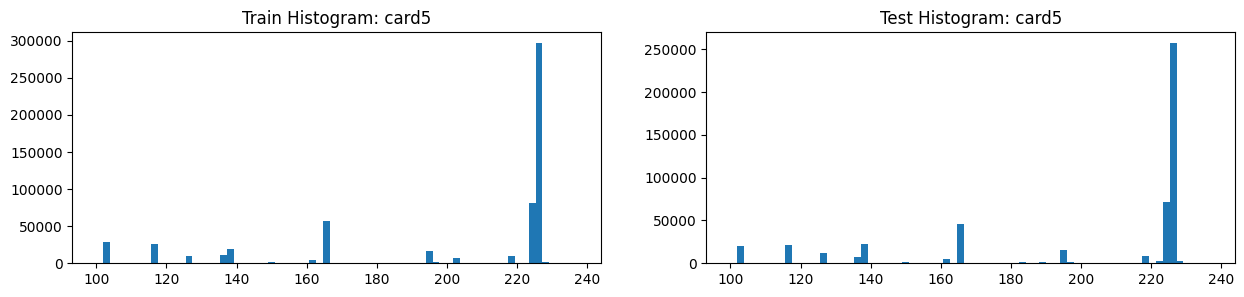

card5          Train          card5   Train Fraud          card5  \
0           count  586281.000000          count  20453.000000          count   
1            mean     199.278897           mean    191.994328           mean   
2             std      41.244453            std     45.779886            std   
3             min     100.000000            min    100.000000            min   
4             25%     166.000000            25%    138.000000            25%   
5             50%     226.000000            50%    224.000000            50%   
6             75%     226.000000            75%    226.000000            75%   
7             max     237.000000            max    237.000000            max   
8   unique values     119.000000  unique values     49.000000  unique values   
9            NaNs    4259.000000           NaNs    210.000000           NaNs   
10     NaNs share       0.007200     NaNs share      0.010200     NaNs share   

    Train Not Fraud          card5           Test          card5  \
0     565828.000000          count  502144.000000          count   
1        199.542212           mean     200.162975           mean   
2         41.046975            std      40.562461            std   
3        100.000000            min     100.000000            min   
4        166.000000            25%     166.000000            25%   
5        226.000000            50%     226.000000            50%   
6        226.000000            75%     226.000000            75%   
7        237.000000            max     237.000000            max   
8        118.000000  unique values     102.000000  unique values   
9       4049.000000           NaNs    4547.000000           NaNs   
10         0.007100     NaNs share       0.009000     NaNs share   

     Test Public          card5   Test Private  
0   99815.000000          count  402329.000000  
1     200.406382           mean     200.102588  
2      40.584597            std      40.556792  
3     100.000000            min     100.000000  
4     166.000000            25%     166.000000  
5     226.000000            50%     226.000000  
6     226.000000            75%     226.000000  
7     237.000000            max     237.000000  
8      69.000000  unique values      96.000000  
9    1523.000000           NaNs    3024.000000  
10      0.015000     NaNs share       0.007500

card5  Train Count  Mean Fraud  Fraud Count  Test Count
109  226.0       296546    0.029516         8753    256991.0
107  224.0        81513    0.038669         3152     71596.0
59   166.0        57140    0.011026          630     45790.0
3    102.0        29105    0.062945         1832     20386.0
15   117.0        25941    0.013646          354     21120.0
35   138.0        19737    0.085221         1682     22102.0
81   195.0        16945    0.040189          681     14951.0
34   137.0        11720    0.147184         1725      7730.0
23   126.0        10298    0.010196          105     11439.0
103  219.0         9924    0.057537          571      8402.0

card5    size      mean   sum  TransactionID
0  226.0  296546  0.029516  8753         256991
1  224.0   81513  0.038669  3152          71596
2  102.0   29105  0.062945  1832          20386
3  137.0   11720  0.147184  1725           7730
4  138.0   19737  0.085221  1682          22102
5  195.0   16945  0.040189   681          14951
6  166.0   57140  0.011026   630          45790
7  219.0    9924  0.057537   571           8402
8  117.0   25941  0.013646   354          21120
9  162.0    4524  0.066534   301           4512

Column  Correlation with card5
7    card5                1.000000
40     D15                0.110301
26      D1                0.099504
27      D2                0.096315
29      D4                0.095706
35     D10                0.095575
373   V333               -0.265948
364   V324               -0.268091
368   V328               -0.270129
369   V329               -0.282868
370   V330               -0.289202

card6   Train          card6 Train Fraud          card6  \
0          count  588969          count       20624          count   
1         unique       4         unique           2         unique   
2            top   debit            top       debit            top   
3           freq  439938           freq       10674           freq   
4  unique values     4.0  unique values         2.0  unique values   
5           NaNs  1571.0           NaNs        39.0           NaNs   
6     NaNs share  0.0027     NaNs share      0.0019     NaNs share   

  Train Not Fraud          card6    Test          card6 Test Public  \
0          568345          count  503684          count      100032   
1               4         unique       3         unique           2   
2           debit            top   debit            top       debit   
3          429264           freq  385021           freq       78401   
4             4.0  unique values     3.0  unique values         2.0   
5          1532.0           NaNs  3007.0           NaNs      1306.0   
6          0.0027     NaNs share  0.0059     NaNs share      0.0129   

           card6 Test Private  
0          count       403652  
1         unique            3  
2            top        debit  
3           freq       306620  
4  unique values          3.0  
5           NaNs       1701.0  
6     NaNs share       0.0042

card6  Train Count  Mean Fraud  Fraud Count  Test Count
3            debit       439938    0.024263        10674    385021.0
2           credit       148986    0.066785         9950    118662.0
0             -999         1571    0.024825           39      3007.0
4  debit or credit           30    0.000000            0         NaN
1      charge card           15    0.000000            0         1.0

card6    size      mean    sum  TransactionID
0            debit  439938  0.024263  10674       385021.0
1           credit  148986  0.066785   9950       118662.0
2             -999    1571  0.024825     39         3007.0
3      charge card      15  0.000000      0            1.0
4  debit or credit      30  0.000000      0            NaN

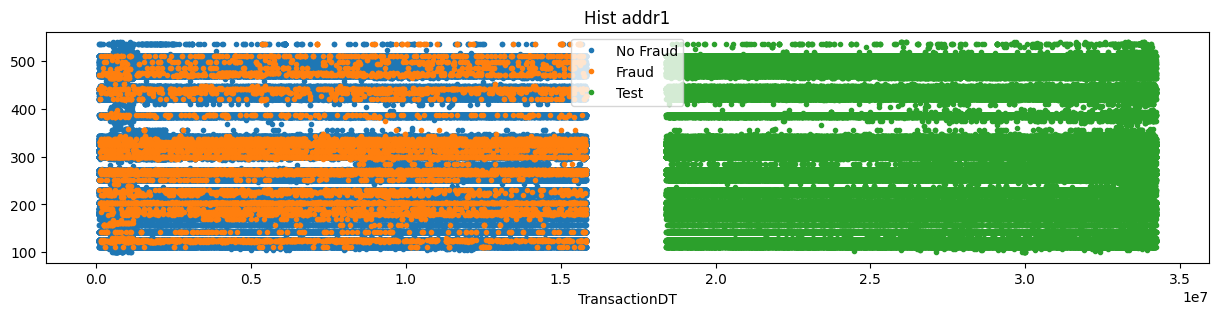

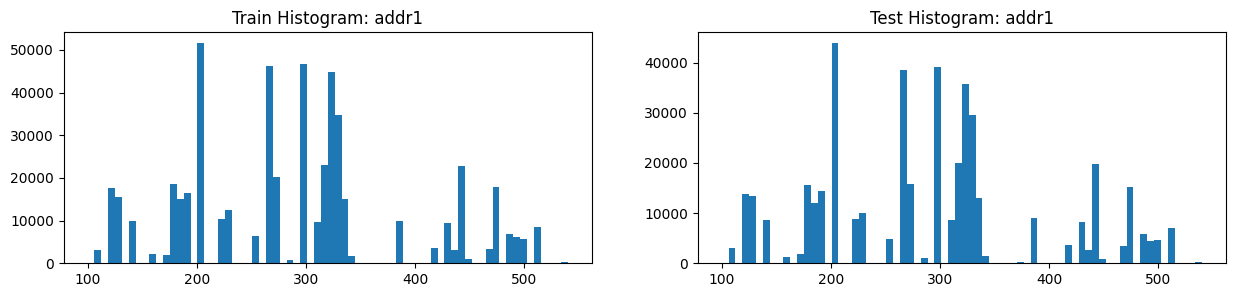

addr1          Train          addr1   Train Fraud          addr1  \
0           count  524834.000000          count  12922.000000          count   
1            mean     290.733794           mean    294.317134           mean   
2             std     101.741072            std    103.584955            std   
3             min     100.000000            min    110.000000            min   
4             25%     204.000000            25%    204.000000            25%   
5             50%     299.000000            50%    299.000000            50%   
6             75%     330.000000            75%    330.000000            75%   
7             max     540.000000            max    536.000000            max   
8   unique values     332.000000  unique values     86.000000  unique values   
9            NaNs   65706.000000           NaNs   7741.000000           NaNs   
10     NaNs share       0.111300     NaNs share      0.374600     NaNs share   

    Train Not Fraud          addr1           Test          addr1  \
0     511912.000000          count  441082.000000          count   
1        290.643341           mean     291.846514           mean   
2        101.692564            std     102.062730            std   
3        100.000000            min     100.000000            min   
4        204.000000            25%     204.000000            25%   
5        299.000000            50%     299.000000            50%   
6        330.000000            75%     330.000000            75%   
7        540.000000            max     540.000000            max   
8        332.000000  unique values     292.000000  unique values   
9      57965.000000           NaNs   65609.000000           NaNs   
10         0.101700     NaNs share       0.129500     NaNs share   

     Test Public          addr1   Test Private  
0   91555.000000          count  349527.000000  
1     290.516192           mean     292.194978  
2     101.350049            std     102.245872  
3     110.000000            min     100.000000  
4     204.000000            25%     204.000000  
5     299.000000            50%     299.000000  
6     330.000000            75%     330.000000  
7     536.000000            max     540.000000  
8      82.000000  unique values     288.000000  
9    9783.000000           NaNs   55826.000000  
10      0.096500     NaNs share       0.137700

addr1  Train Count  Mean Fraud  Fraud Count  Test Count
0   -999.0        65706    0.117813         7741     65609.0
152  299.0        46335    0.021258          985     38710.0
174  325.0        42751    0.025426         1087     34151.0
79   204.0        42020    0.026654         1120     35049.0
128  264.0        39870    0.018259          728     32710.0
179  330.0        26287    0.031955          840     22100.0
167  315.0        23078    0.017809          411     19957.0
256  441.0        20827    0.025592          533     18063.0
133  272.0        20141    0.028598          576     15788.0
15   123.0        16105    0.024713          398     12595.0

addr1   size      mean   sum  TransactionID
0 -999.0  65706  0.117813  7741          65609
1  204.0  42020  0.026654  1120          35049
2  325.0  42751  0.025426  1087          34151
3  299.0  46335  0.021258   985          38710
4  330.0  26287  0.031955   840          22100
5  264.0  39870  0.018259   728          32710
6  272.0  20141  0.028598   576          15788
7  441.0  20827  0.025592   533          18063
8  337.0  15149  0.028979   439          12932
9  315.0  23078  0.017809   411          19957

Column  Correlation with addr1
8    addr1                1.000000
366   V326                0.050944
38     D13                0.050886
367   V327                0.047731
370   V330                0.042601
369   V329                0.042381
140   V100               -0.019761
139    V99               -0.021358
327   V287               -0.022924
325   V285               -0.028060
32      D7               -0.079024

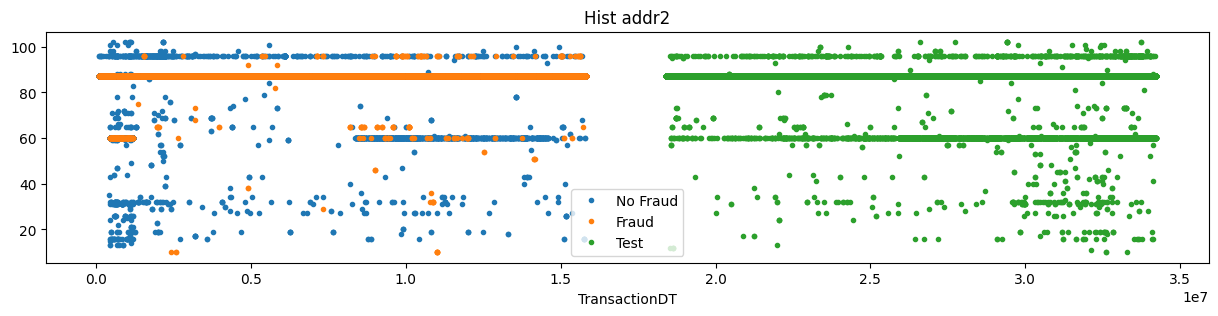

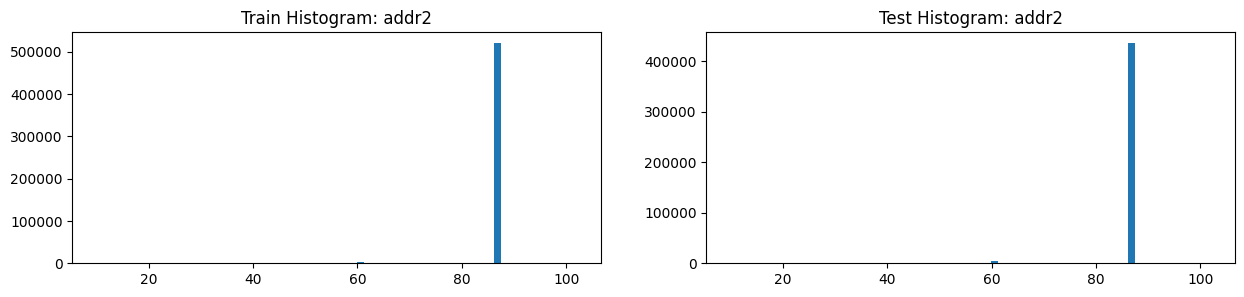

addr2          Train          addr2   Train Fraud          addr2  \
0           count  524834.000000          count  12922.000000          count   
1            mean      86.800630           mean     86.286024           mean   
2             std       2.690623            std      4.936238            std   
3             min      10.000000            min     10.000000            min   
4             25%      87.000000            25%     87.000000            25%   
5             50%      87.000000            50%     87.000000            50%   
6             75%      87.000000            75%     87.000000            75%   
7             max     102.000000            max     96.000000            max   
8   unique values      74.000000  unique values     17.000000  unique values   
9            NaNs   65706.000000           NaNs   7741.000000           NaNs   
10     NaNs share       0.111300     NaNs share      0.374600     NaNs share   

    Train Not Fraud          addr2           Test          addr2  \
0     511912.000000          count  441082.000000          count   
1         86.813620           mean      86.723412           mean   
2          2.607742            std       2.987328            std   
3         13.000000            min      10.000000            min   
4         87.000000            25%      87.000000            25%   
5         87.000000            50%      87.000000            50%   
6         87.000000            75%      87.000000            75%   
7        102.000000            max     102.000000            max   
8         68.000000  unique values      72.000000  unique values   
9      57965.000000           NaNs   65609.000000           NaNs   
10         0.101700     NaNs share       0.129500     NaNs share   

     Test Public          addr2   Test Private  
0   91555.000000          count  349527.000000  
1      86.964371           mean      86.660295  
2       1.217611            std       3.294569  
3      12.000000            min      10.000000  
4      87.000000            25%      87.000000  
5      87.000000            50%      87.000000  
6      87.000000            75%      87.000000  
7      96.000000            max     102.000000  
8      17.000000  unique values      71.000000  
9    9783.000000           NaNs   55826.000000  
10      0.096500     NaNs share       0.137700

addr2  Train Count  Mean Fraud  Fraud Count  Test Count
63   87.0       520481    0.023972        12477    435934.0
0  -999.0        65706    0.117813         7741     65609.0
41   60.0         3084    0.090467          279      4041.0
69   96.0          638    0.139498           89       608.0
21   32.0           91    0.065934            6        61.0
45   65.0           82    0.536585           44        49.0
5    16.0           55    0.000000            0        22.0
20   31.0           47    0.000000            0        36.0
8    19.0           33    0.000000            0        23.0
15   26.0           25    0.000000            0         7.0

addr2    size      mean    sum  TransactionID
0   87.0  520481  0.023972  12477         435934
1 -999.0   65706  0.117813   7741          65609
2   60.0    3084  0.090467    279           4041
3   96.0     638  0.139498     89            608
4   65.0      82  0.536585     44             49
5   10.0       8  1.000000      8              3
6   32.0      91  0.065934      6             61
7   51.0       4  1.000000      4              1
8   46.0       3  1.000000      3              1
9   38.0       3  0.666667      2              5

Column  Correlation with addr2
9    addr2                1.000000
31      D6                0.290653
38     D13                0.208817
39     D14                0.142099
76     V36                0.113776
75     V35                0.110642
56     V16               -0.712508
55     V15               -0.819340
98     V58               -0.876798
97     V57               -0.876965
119    V79               -0.890125

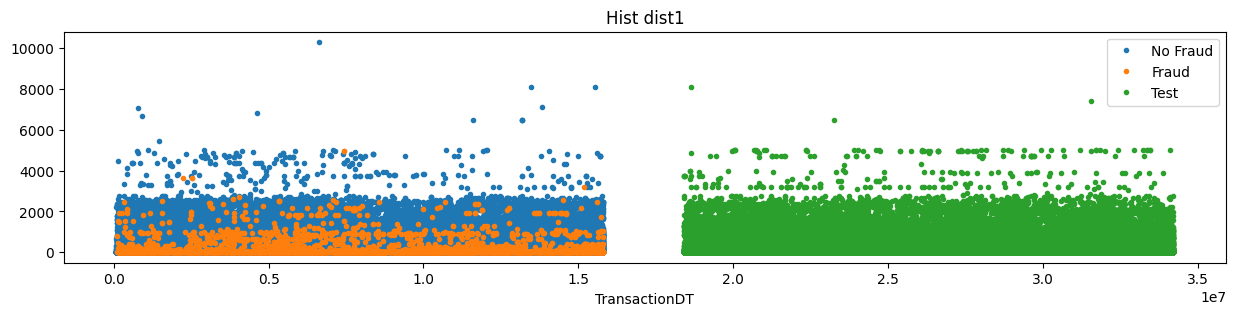

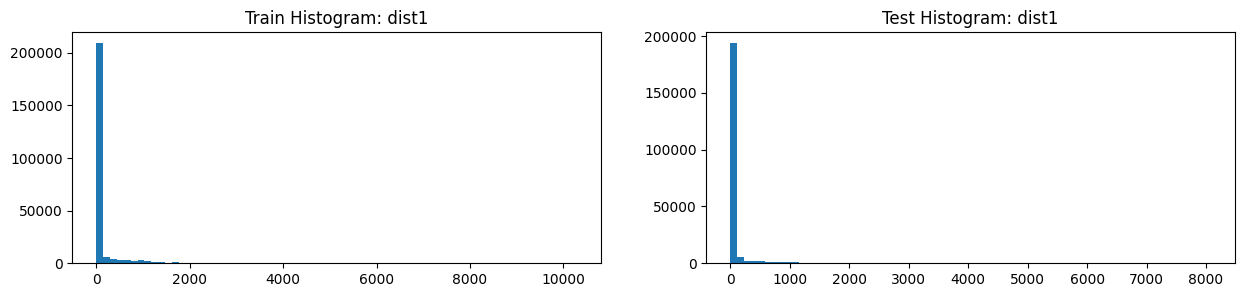

dist1          Train          dist1   Train Fraud          dist1  \
0           count  238269.000000          count   4755.000000          count   
1            mean     118.502180           mean    174.588854           mean   
2             std     371.872026            std    424.232313            std   
3             min       0.000000            min      0.000000            min   
4             25%       3.000000            25%      3.000000            25%   
5             50%       8.000000            50%     10.000000            50%   
6             75%      24.000000            75%     85.500000            75%   
7             max   10286.000000            max   4942.000000            max   
8   unique values    2651.000000  unique values    470.000000  unique values   
9            NaNs  352271.000000           NaNs  15908.000000           NaNs   
10     NaNs share       0.596500     NaNs share      0.769900     NaNs share   

    Train Not Fraud          dist1           Test          dist1  \
0     233514.000000          count  215474.000000          count   
1        117.360098           mean      87.065270           mean   
2        370.641879            std     314.131694            std   
3          0.000000            min       0.000000            min   
4          3.000000            25%       3.000000            25%   
5          8.000000            50%       8.000000            50%   
6         24.000000            75%      20.000000            75%   
7      10286.000000            max    8081.000000            max   
8       2635.000000  unique values    1988.000000  unique values   
9     336363.000000           NaNs  291217.000000           NaNs   
10         0.590200     NaNs share       0.574700     NaNs share   

     Test Public          dist1   Test Private  
0   47586.000000          count  167888.000000  
1      92.925146           mean      85.404353  
2     332.384459            std     308.742753  
3       0.000000            min       0.000000  
4       3.000000            25%       3.000000  
5       8.000000            50%       8.000000  
6      20.000000            75%      20.000000  
7    8081.000000            max    7385.000000  
8    1346.000000  unique values    1842.000000  
9   53752.000000           NaNs  237465.000000  
10      0.530400     NaNs share       0.585800

dist1  Train Count  Mean Fraud  Fraud Count  Test Count
0 -999.0       352271    0.045158        15908    291217.0
1    0.0        19824    0.019169          380     19278.0
2    1.0        18330    0.027932          512     18025.0
3    2.0        17028    0.011745          200     15687.0
5    4.0        13067    0.016454          215     12137.0
4    3.0        12808    0.011711          150     12333.0
6    5.0        12004    0.022243          267     11238.0
7    6.0         9843    0.014630          144      8775.0
8    7.0         9340    0.014668          137      9210.0
9    8.0         7731    0.015134          117      7333.0

dist1    size      mean    sum  TransactionID
0 -999.0  352271  0.045158  15908         291217
1    1.0   18330  0.027932    512          18025
2    0.0   19824  0.019169    380          19278
3    5.0   12004  0.022243    267          11238
4    4.0   13067  0.016454    215          12137
5    2.0   17028  0.011745    200          15687
6    3.0   12808  0.011711    150          12333
7    9.0    7728  0.018892    146           7608
8    6.0    9843  0.014630    144           8775
9    7.0    9340  0.014668    137           9210

Column  Correlation with dist1
10  dist1                1.000000
34     V8                0.094938
35     V9                0.088465
28     V2                0.079191
32     V6                0.076624
29     V3                0.067514
85    V91               -0.066577
72    V70               -0.066690
84    V90               -0.068074
71    V69               -0.068412
46    V29               -0.069451

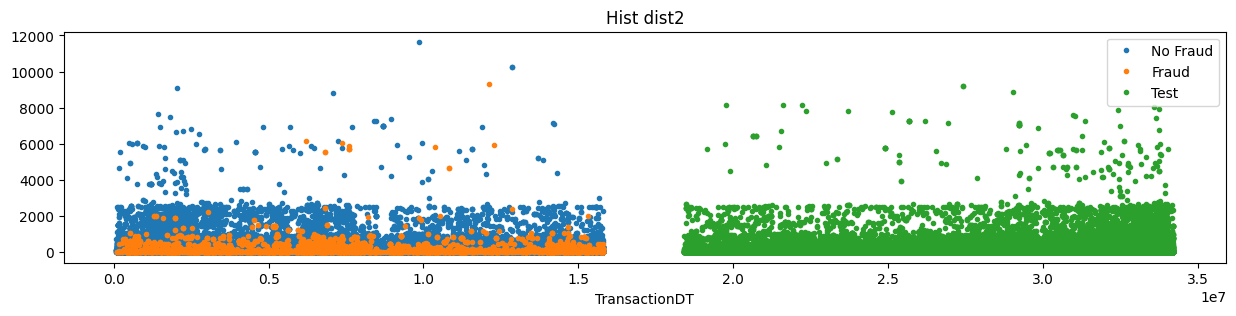

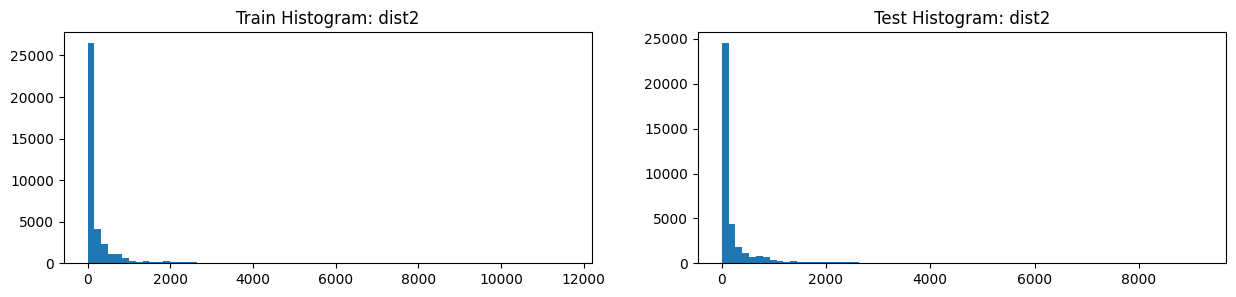

dist2          Train          dist2   Train Fraud          dist2  \
0           count   37627.000000          count   3731.000000          count   
1            mean     231.855423           mean    201.472259           mean   
2             std     529.053494            std    451.589576            std   
3             min       0.000000            min      0.000000            min   
4             25%       7.000000            25%      7.000000            25%   
5             50%      37.000000            50%     49.000000            50%   
6             75%     206.000000            75%    233.000000            75%   
7             max   11623.000000            max   9337.000000            max   
8   unique values    1751.000000  unique values    344.000000  unique values   
9            NaNs  552913.000000           NaNs  16932.000000           NaNs   
10     NaNs share       0.936300     NaNs share      0.819400     NaNs share   

    Train Not Fraud          dist2           Test          dist2  \
0      33896.000000          count   36436.000000          count   
1        235.199758           mean     237.175047           mean   
2        536.798492            std     556.450834            std   
3          0.000000            min       0.000000            min   
4          7.000000            25%       7.000000            25%   
5         36.000000            50%      44.000000            50%   
6        206.000000            75%     196.000000            75%   
7      11623.000000            max    9213.000000            max   
8       1723.000000  unique values    1814.000000  unique values   
9     535981.000000           NaNs  470255.000000           NaNs   
10         0.940500     NaNs share       0.928100     NaNs share   

     Test Public          dist2   Test Private  
0    4716.000000          count   31720.000000  
1     233.553223           mean     237.713525  
2     555.365698            std     556.618714  
3       0.000000            min       0.000000  
4       7.000000            25%       7.000000  
5      50.000000            50%      42.000000  
6     190.000000            75%     196.000000  
7    8169.000000            max    9213.000000  
8     610.000000  unique values    1729.000000  
9   96622.000000           NaNs  373633.000000  
10      0.953500     NaNs share       0.921700

dist2  Train Count  Mean Fraud  Fraud Count  Test Count
0  -999.0       552913    0.030623        16932    470255.0
8     7.0         5687    0.087216          496      2660.0
1     0.0         3519    0.153453          540      2821.0
2     1.0         1374    0.139738          192      1565.0
10    9.0          742    0.148248          110       993.0
5     4.0          659    0.071320           47       557.0
3     2.0          556    0.035971           20       805.0
4     3.0          490    0.077551           38       606.0
69   68.0          485    0.096907           47       342.0
7     6.0          412    0.024272           10       497.0

dist2    size      mean    sum  TransactionID
0 -999.0  552913  0.030623  16932         470255
1    0.0    3519  0.153453    540           2821
2    7.0    5687  0.087216    496           2660
3    1.0    1374  0.139738    192           1565
4    9.0     742  0.148248    110            993
5   17.0     257  0.276265     71            367
6  199.0     362  0.193370     70            138
7   49.0     110  0.509091     56             74
8  478.0     102  0.539216     55             25
9  150.0     215  0.237209     51             43

Column  Correlation with dist2
10   dist2                1.000000
200   V192                0.102090
195   V187                0.094572
201   V193                0.091043
242   V234                0.076003
199   V191                0.066564
268   V260               -0.044111
28      D6               -0.045920
26      D4               -0.058390
33     D12               -0.075249
6    card3               -0.143222

P_emaildomain      Train  P_emaildomain Train Fraud  P_emaildomain  \
0          count     496084          count       17873          count   
1         unique         59         unique          42         unique   
2            top  gmail.com            top   gmail.com            top   
3           freq     228355           freq        9943           freq   
4  unique values       59.0  unique values        42.0  unique values   
5           NaNs    94456.0           NaNs      2790.0           NaNs   
6     NaNs share     0.1599     NaNs share       0.135     NaNs share   

  Train Not Fraud  P_emaildomain       Test  P_emaildomain Test Public  \
0          478211          count     437499          count       85890   
1              59         unique         60         unique          59   
2       gmail.com            top  gmail.com            top   gmail.com   
3          218412           freq     207448           freq       41103   
4            59.0  unique values       60.0  unique values        59.0   
5         91666.0           NaNs    69192.0           NaNs     15448.0   
6          0.1609     NaNs share     0.1366     NaNs share      0.1524   

   P_emaildomain Test Private  
0          count       351609  
1         unique           60  
2            top    gmail.com  
3           freq       166345  
4  unique values         60.0  
5           NaNs      53744.0  
6     NaNs share       0.1326

P_emaildomain  Train Count  Mean Fraud  Fraud Count  Test Count
17      gmail.com       228355    0.043542         9943      207448
54      yahoo.com       100934    0.022757         2297       81850
0            -999        94456    0.029538         2790       69192
20    hotmail.com        45250    0.052950         2396       40399
2   anonymous.com        36998    0.023217          859       34064
3         aol.com        28289    0.021811          617       24048
10    comcast.net         7888    0.031187          246        6586
24     icloud.com         6267    0.031434          197        6049
36    outlook.com         5096    0.094584          482        4838
32        msn.com         4092    0.021994           90        3388

P_emaildomain    size      mean   sum  TransactionID
0      gmail.com  228355  0.043542  9943         207448
1           -999   94456  0.029538  2790          69192
2    hotmail.com   45250  0.052950  2396          40399
3      yahoo.com  100934  0.022757  2297          81850
4  anonymous.com   36998  0.023217   859          34064
5        aol.com   28289  0.021811   617          24048
6    outlook.com    5096  0.094584   482           4838
7    comcast.net    7888  0.031187   246           6586
8     icloud.com    6267  0.031434   197           6049
9       mail.com     559  0.189624   106            597

R_emaildomain      Train  R_emaildomain Train Fraud  R_emaildomain  \
0          count     137291          count       11227          count   
1         unique         60         unique          32         unique   
2            top  gmail.com            top   gmail.com            top   
3           freq      57147           freq        6811           freq   
4  unique values       60.0  unique values        32.0  unique values   
5           NaNs   453249.0           NaNs      9436.0           NaNs   
6     NaNs share     0.7675     NaNs share      0.4567     NaNs share   

  Train Not Fraud  R_emaildomain       Test  R_emaildomain Test Public  \
0          126064          count     135870          count       18223   
1              60         unique         60         unique          57   
2       gmail.com            top  gmail.com            top   gmail.com   
3           50336           freq      61738           freq        8588   
4            60.0  unique values       60.0  unique values        57.0   
5        443813.0           NaNs   370821.0           NaNs     83115.0   
6          0.7788     NaNs share     0.7318     NaNs share      0.8202   

   R_emaildomain Test Private  
0          count       117647  
1         unique           60  
2            top    gmail.com  
3           freq        53150  
4  unique values         60.0  
5           NaNs     287706.0  
6     NaNs share       0.7098

R_emaildomain  Train Count  Mean Fraud  Fraud Count  Test Count
0            -999       453249    0.020819         9436      370821
17      gmail.com        57147    0.119184         6811       61738
20    hotmail.com        27509    0.077793         2140       25657
2   anonymous.com        20529    0.029130          598       19115
55      yahoo.com        11842    0.051512          610        9563
3         aol.com         3701    0.034855          129        3538
36    outlook.com         2507    0.165138          414        2504
10    comcast.net         1812    0.011589           21        1701
56   yahoo.com.mx         1508    0.010610           16        1235
24     icloud.com         1398    0.128755          180        1422

R_emaildomain    size      mean   sum  TransactionID
0           -999  453249  0.020819  9436         370821
1      gmail.com   57147  0.119184  6811          61738
2    hotmail.com   27509  0.077793  2140          25657
3      yahoo.com   11842  0.051512   610           9563
4  anonymous.com   20529  0.029130   598          19115
5    outlook.com    2507  0.165138   414           2504
6     icloud.com    1398  0.128755   180           1422
7        aol.com    3701  0.034855   129           3538
8     outlook.es     433  0.131640    57            420
9       mail.com     122  0.377049    46            219

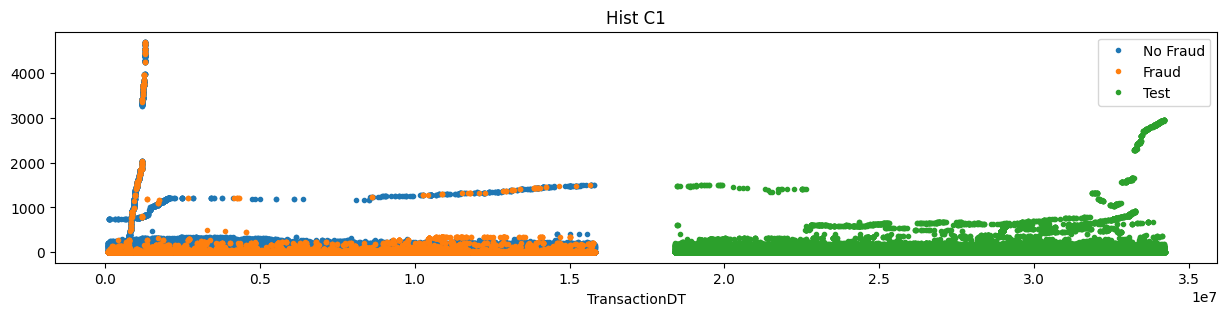

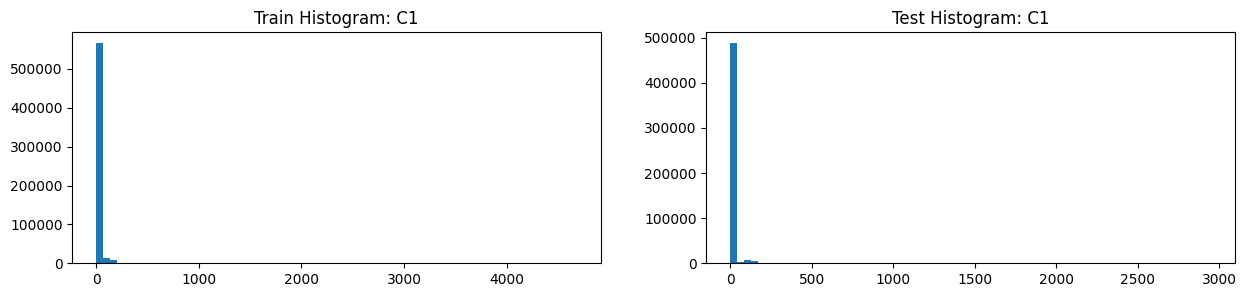

C1          Train             C1  Train Fraud             C1  \
0           count  590540.000000          count  20663.00000          count   
1            mean      14.092458           mean     35.53574           mean   
2             std     133.569018            std    242.97626            std   
3             min       0.000000            min      0.00000            min   
4             25%       1.000000            25%      1.00000            25%   
5             50%       1.000000            50%      2.00000            50%   
6             75%       3.000000            75%      6.00000            75%   
7             max    4685.000000            max   4682.00000            max   
8   unique values    1657.000000  unique values    497.00000  unique values   
9            NaNs       0.000000           NaNs      0.00000           NaNs   
10     NaNs share       0.000000     NaNs share      0.00000     NaNs share   

    Train Not Fraud             C1           Test             C1  \
0     569877.000000          count  506688.000000          count   
1         13.314952           mean      10.093211           mean   
2        127.787969            std      79.334782            std   
3          0.000000            min       0.000000            min   
4          1.000000            25%       1.000000            25%   
5          1.000000            50%       1.000000            50%   
6          3.000000            75%       3.000000            75%   
7       4685.000000            max    2950.000000            max   
8       1526.000000  unique values    1174.000000  unique values   
9          0.000000           NaNs       3.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public             C1   Test Private  
0   101338.000000          count  405350.000000  
1        8.408761           mean      10.514326  
2       40.872409            std      86.307573  
3        0.000000            min       0.000000  
4        1.000000            25%       1.000000  
5        2.000000            50%       1.000000  
6        3.000000            75%       3.000000  
7     1501.000000            max    2950.000000  
8      344.000000  unique values    1117.000000  
9        0.000000           NaNs       3.000000  
10       0.000000     NaNs share       0.000000

C1  Train Count  Mean Fraud  Fraud Count  Test Count
1    1.0       316791    0.024230         7676    269951.0
2    2.0       105071    0.030284         3182     92449.0
3    3.0        51315    0.035876         1841     45254.0
4    4.0        28845    0.040596         1171     24949.0
5    5.0        17922    0.054179          971     14929.0
6    6.0        10567    0.053658          567      9207.0
7    7.0         7263    0.058240          423      5721.0
8    8.0         5072    0.066246          336      3996.0
9    9.0         3612    0.080011          289      2771.0
10  10.0         2904    0.091942          267      1969.0

C1    size      mean   sum  TransactionID
0   1.0  316791  0.024230  7676         269951
1   2.0  105071  0.030284  3182          92449
2   3.0   51315  0.035876  1841          45254
3   4.0   28845  0.040596  1171          24949
4   5.0   17922  0.054179   971          14929
5   6.0   10567  0.053658   567           9207
6   7.0    7263  0.058240   423           5721
7   8.0    5072  0.066246   336           3996
8   9.0    3612  0.080011   289           2771
9  10.0    2904  0.091942   267           1969

Column  Correlation with C1
12              C1             1.000000
22             C11             0.996515
13              C2             0.995089
17              C6             0.982238
15              C4             0.967800
19              C8             0.967746
115            V75            -0.051347
116            V76            -0.051632
0    TransactionID            -0.053154
75             V35            -0.054029
76             V36            -0.054554

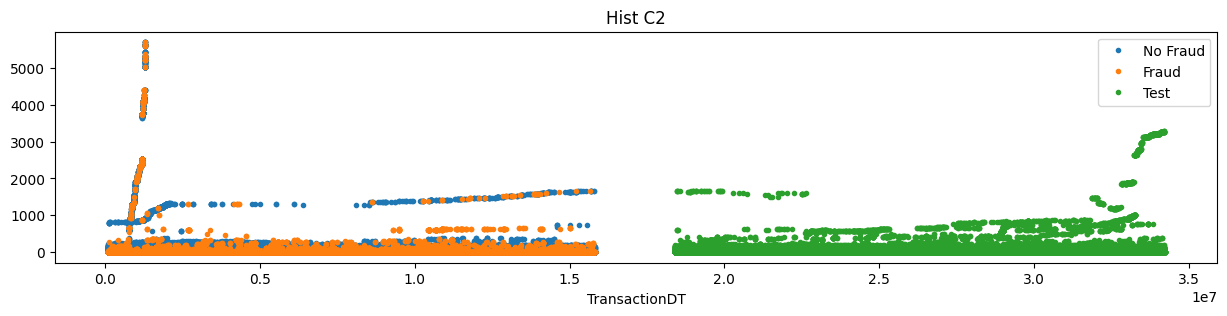

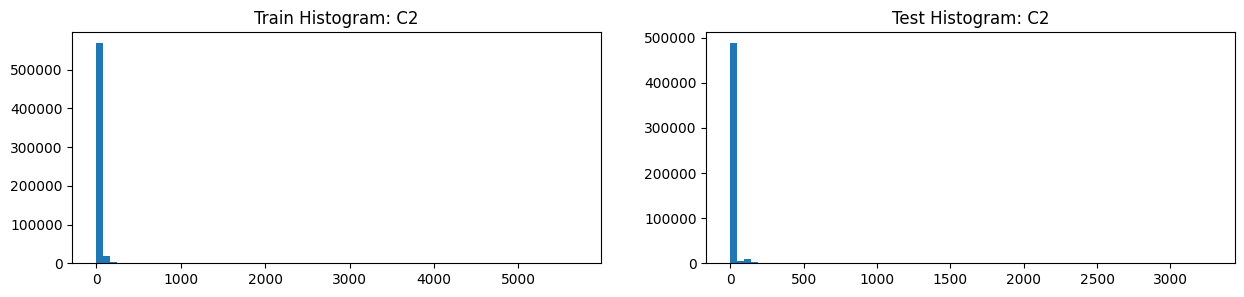

C2          Train             C2   Train Fraud             C2  \
0           count  590540.000000          count  20663.000000          count   
1            mean      15.269734           mean     45.509413           mean   
2             std     154.668899            std    287.813648            std   
3             min       0.000000            min      0.000000            min   
4             25%       1.000000            25%      1.000000            25%   
5             50%       1.000000            50%      2.000000            50%   
6             75%       3.000000            75%      7.000000            75%   
7             max    5691.000000            max   5690.000000            max   
8   unique values    1216.000000  unique values    544.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud             C2           Test             C2  \
0     569877.000000          count  506688.000000          count   
1         14.173283           mean      10.714635           mean   
2        147.485925            std      88.896921            std   
3          0.000000            min       0.000000            min   
4          1.000000            25%       1.000000            25%   
5          1.000000            50%       1.000000            50%   
6          3.000000            75%       3.000000            75%   
7       5691.000000            max    3275.000000            max   
8       1075.000000  unique values    1123.000000  unique values   
9          0.000000           NaNs       3.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public             C2   Test Private  
0   101338.000000          count  405350.000000  
1        8.606988           mean      11.241549  
2       44.375552            std      96.874447  
3        0.000000            min       0.000000  
4        1.000000            25%       1.000000  
5        2.000000            50%       1.000000  
6        3.000000            75%       3.000000  
7     1672.000000            max    3275.000000  
8      370.000000  unique values    1053.000000  
9        0.000000           NaNs       3.000000  
10       0.000000     NaNs share       0.000000

C2  Train Count  Mean Fraud  Fraud Count  Test Count
1    1.0       316261    0.023073         7297    265435.0
2    2.0       103948    0.031978         3324     93084.0
3    3.0        51770    0.036160         1872     44267.0
4    4.0        28251    0.050370         1423     24329.0
5    5.0        16971    0.049496          840     14711.0
6    6.0        10682    0.049991          534      9662.0
7    7.0         7382    0.060824          449      6097.0
8    8.0         5105    0.053477          273      4387.0
9    9.0         3750    0.058933          221      3364.0
10  10.0         2797    0.085449          239      2432.0

C2    size      mean   sum  TransactionID
0   1.0  316261  0.023073  7297         265435
1   2.0  103948  0.031978  3324          93084
2   3.0   51770  0.036160  1872          44267
3   4.0   28251  0.050370  1423          24329
4   5.0   16971  0.049496   840          14711
5   6.0   10682  0.049991   534           9662
6   7.0    7382  0.060824   449           6097
7   8.0    5105  0.053477   273           4387
8  10.0    2797  0.085449   239           2432
9   9.0    3750  0.058933   221           3364

Column  Correlation with C2
13              C2             1.000000
12              C1             0.995089
22             C11             0.993898
19              C8             0.975863
17              C6             0.974845
15              C4             0.972134
0    TransactionID            -0.055186
115            V75            -0.056251
116            V76            -0.056896
75             V35            -0.059538
76             V36            -0.060269

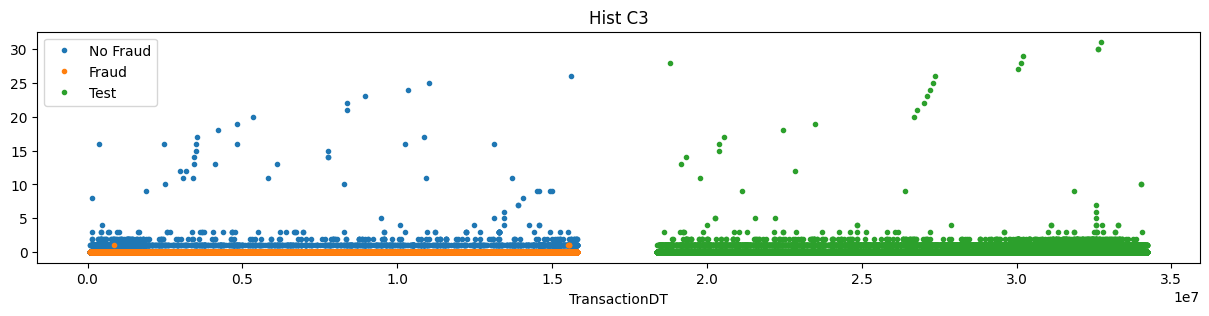

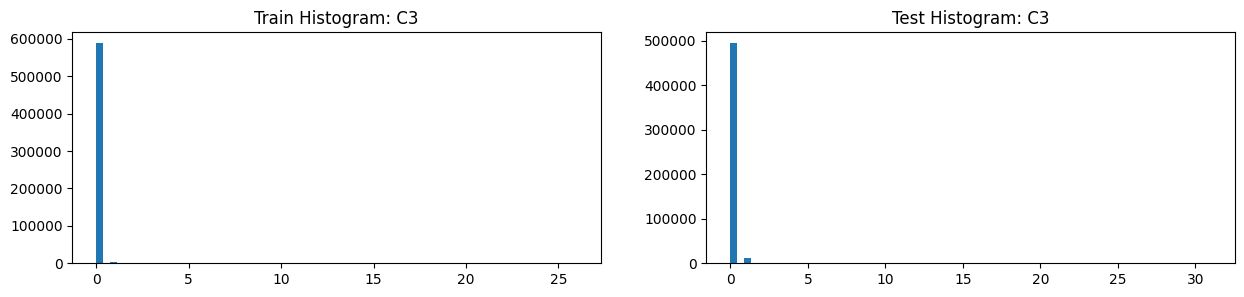

C3          Train             C3   Train Fraud             C3  \
0           count  590540.000000          count  20663.000000          count   
1            mean       0.005644           mean      0.000242           mean   
2             std       0.150536            std      0.015554            std   
3             min       0.000000            min      0.000000            min   
4             25%       0.000000            25%      0.000000            25%   
5             50%       0.000000            50%      0.000000            50%   
6             75%       0.000000            75%      0.000000            75%   
7             max      26.000000            max      1.000000            max   
8   unique values      27.000000  unique values      2.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud             C3           Test             C3  \
0     569877.000000          count  506688.000000          count   
1          0.005840           mean       0.027403           mean   
2          0.153208            std       0.227753            std   
3          0.000000            min       0.000000            min   
4          0.000000            25%       0.000000            25%   
5          0.000000            50%       0.000000            50%   
6          0.000000            75%       0.000000            75%   
7         26.000000            max      31.000000            max   
8         27.000000  unique values      31.000000  unique values   
9          0.000000           NaNs       3.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public             C3   Test Private  
0   101338.000000          count  405350.000000  
1        0.009365           mean       0.031913  
2        0.176031            std       0.238727  
3        0.000000            min       0.000000  
4        0.000000            25%       0.000000  
5        0.000000            50%       0.000000  
6        0.000000            75%       0.000000  
7       28.000000            max      31.000000  
8       14.000000  unique values      25.000000  
9        0.000000           NaNs       3.000000  
10       0.000000     NaNs share       0.000000

C3  Train Count  Mean Fraud  Fraud Count  Test Count
0    0.0       588111    0.035126        20658    493779.0
1    1.0         2137    0.002340            5     12506.0
2    2.0          180    0.000000            0       320.0
3    3.0           58    0.000000            0        37.0
4    4.0            7    0.000000            0        11.0
16  16.0            6    0.000000            0         1.0
9    9.0            5    0.000000            0         3.0
11  11.0            5    0.000000            0         1.0
5    5.0            3    0.000000            0         5.0
13  13.0            3    0.000000            0         1.0

C3    size      mean    sum  TransactionID
0  0.0  588111  0.035126  20658       493779.0
1  1.0    2137  0.002340      5        12506.0
2  2.0     180  0.000000      0          320.0
3  3.0      58  0.000000      0           37.0
4  4.0       7  0.000000      0           11.0
5  5.0       3  0.000000      0            5.0
6  6.0       1  0.000000      0            1.0
7  7.0       2  0.000000      0            1.0
8  8.0       2  0.000000      0            NaN
9  9.0       5  0.000000      0            3.0

Column  Correlation with C3
13      C3             1.000000
54     V28             0.593655
115    V89             0.592326
94     V68             0.554881
53     V27             0.548193
30      D6             0.090308
181   V155            -0.039395
108    V82            -0.040171
174   V148            -0.040378
180   V154            -0.041643
179   V153            -0.041988

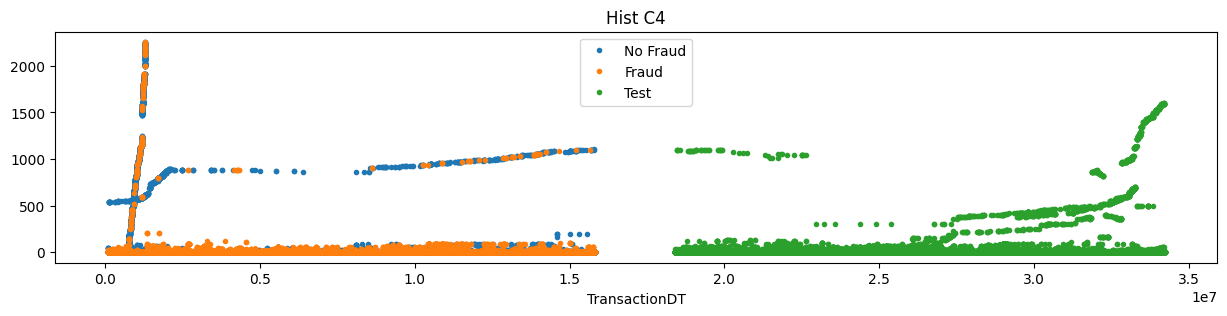

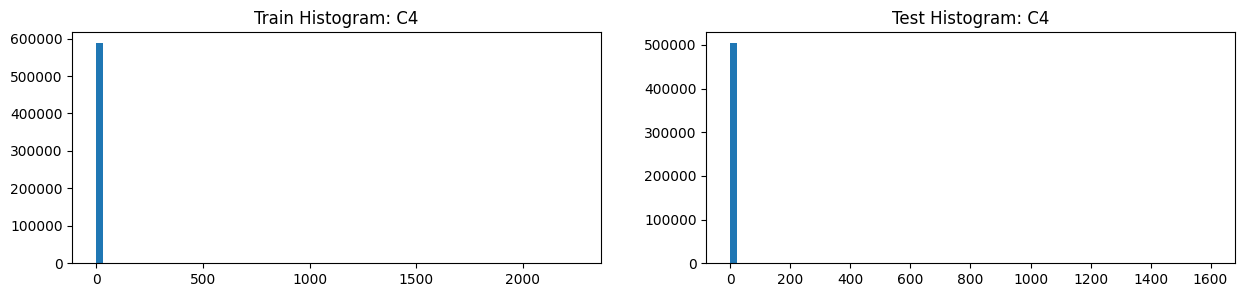

C4          Train             C4   Train Fraud             C4  \
0           count  590540.000000          count  20663.000000          count   
1            mean       4.092185           mean     15.077336           mean   
2             std      68.848459            std    125.673738            std   
3             min       0.000000            min      0.000000            min   
4             25%       0.000000            25%      0.000000            25%   
5             50%       0.000000            50%      1.000000            50%   
6             75%       0.000000            75%      2.000000            75%   
7             max    2253.000000            max   2251.000000            max   
8   unique values    1260.000000  unique values    224.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud             C4           Test             C4  \
0     569877.000000          count  506688.000000          count   
1          3.693878           mean       2.385875           mean   
2         65.839255            std      41.942977            std   
3          0.000000            min       0.000000            min   
4          0.000000            25%       0.000000            25%   
5          0.000000            50%       0.000000            50%   
6          0.000000            75%       1.000000            75%   
7       2253.000000            max    1601.000000            max   
8       1180.000000  unique values     728.000000  unique values   
9          0.000000           NaNs       3.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

     Test Public             C4   Test Private  
0   101338.00000          count  405350.000000  
1        0.98505           mean       2.736082  
2       23.11619            std      45.440263  
3        0.00000            min       0.000000  
4        0.00000            25%       0.000000  
5        0.00000            50%       0.000000  
6        0.00000            75%       1.000000  
7     1100.00000            max    1601.000000  
8       99.00000  unique values     697.000000  
9        0.00000           NaNs       3.000000  
10       0.00000     NaNs share       0.000000

C4  Train Count  Mean Fraud  Fraud Count  Test Count
0    0.0       451883    0.020386         9212    371571.0
1    1.0       111817    0.051298         5736    107826.0
2    2.0        12994    0.128444         1669     13702.0
3    3.0         4949    0.144070          713      4307.0
4    4.0         1902    0.305468          581      1759.0
5    5.0          851    0.404230          344      1159.0
6    6.0          597    0.402010          240       713.0
7    7.0          372    0.325269          121       482.0
9    9.0          273    0.545788          149       298.0
10  10.0          233    0.682403          159       305.0

C4    size      mean   sum  TransactionID
0   0.0  451883  0.020386  9212         371571
1   1.0  111817  0.051298  5736         107826
2   2.0   12994  0.128444  1669          13702
3   3.0    4949  0.144070   713           4307
4   4.0    1902  0.305468   581           1759
5   5.0     851  0.404230   344           1159
6   6.0     597  0.402010   240            713
7  10.0     233  0.682403   159            305
8   9.0     273  0.545788   149            298
9   7.0     372  0.325269   121            482

Column  Correlation with C4
14      C4             1.000000
21     C11             0.974547
12      C2             0.972134
11      C1             0.967800
16      C6             0.962319
18      C8             0.959995
81     V54            -0.057470
224   V197            -0.058750
62     V35            -0.058768
63     V36            -0.060052
221   V194            -0.070506

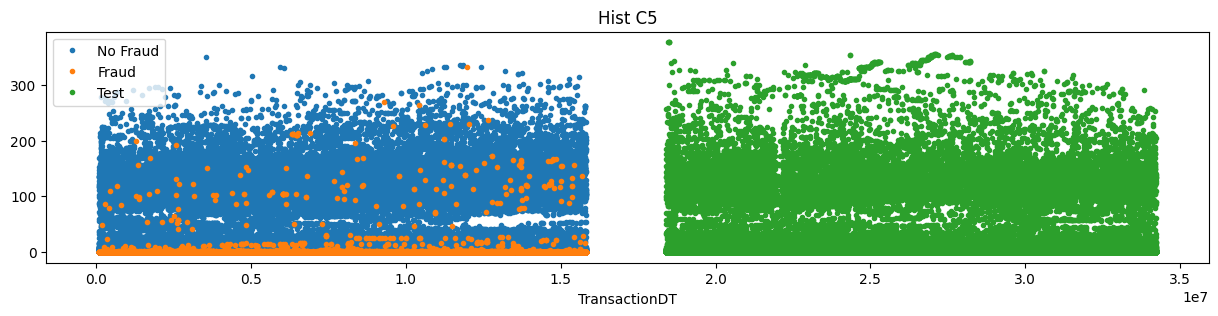

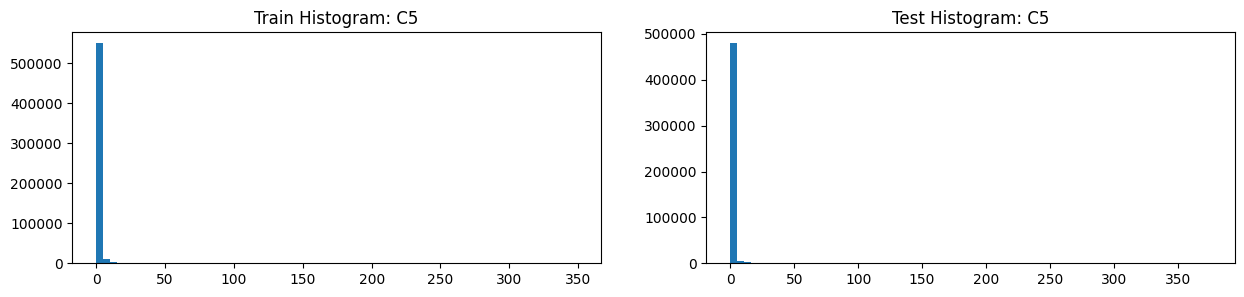

C5          Train             C5   Train Fraud             C5  \
0           count  590540.000000          count  20663.000000          count   
1            mean       5.571526           mean      1.406717           mean   
2             std      25.786976            std     12.946092            std   
3             min       0.000000            min      0.000000            min   
4             25%       0.000000            25%      0.000000            25%   
5             50%       0.000000            50%      0.000000            50%   
6             75%       1.000000            75%      0.000000            75%   
7             max     349.000000            max    331.000000            max   
8   unique values     319.000000  unique values    124.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud             C5           Test             C5  \
0     569877.000000          count  506688.000000          count   
1          5.722537           mean       4.962701           mean   
2         26.121841            std      25.462195            std   
3          0.000000            min       0.000000            min   
4          0.000000            25%       0.000000            25%   
5          0.000000            50%       0.000000            50%   
6          1.000000            75%       1.000000            75%   
7        349.000000            max     376.000000            max   
8        319.000000  unique values     353.000000  unique values   
9          0.000000           NaNs       3.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public             C5   Test Private  
0   101338.000000          count  405350.000000  
1        5.711530           mean       4.775493  
2       26.488499            std      25.195644  
3        0.000000            min       0.000000  
4        0.000000            25%       0.000000  
5        0.000000            50%       0.000000  
6        1.000000            75%       1.000000  
7      376.000000            max     355.000000  
8      300.000000  unique values     352.000000  
9        0.000000           NaNs       3.000000  
10       0.000000     NaNs share       0.000000

C5  Train Count  Mean Fraud  Fraud Count  Test Count
0  0.0       372435    0.050369        18759      334573
1  1.0       122883    0.007560          929       96588
2  2.0        34776    0.010956          381       29363
3  3.0        13189    0.011980          158       10699
4  4.0         6828    0.006591           45        5446
5  5.0         3763    0.004252           16        2832
6  6.0         2837    0.004230           12        1938
7  7.0         1906    0.003673            7        1369
8  8.0         1443    0.009009           13         991
9  9.0         1076    0.009294           10         905

C5    size      mean    sum  TransactionID
0   0.0  372435  0.050369  18759         334573
1   1.0  122883  0.007560    929          96588
2   2.0   34776  0.010956    381          29363
3   3.0   13189  0.011980    158          10699
4   4.0    6828  0.006591     45           5446
5  14.0     420  0.054762     23            450
6  26.0     203  0.113300     23            119
7  13.0     583  0.029160     17            546
8   5.0    3763  0.004252     16           2832
9   8.0    1443  0.009009     13            991

Column  Correlation with C5
15      C5             1.000000
19      C9             0.925786
23     C13             0.717509
24     C14             0.378950
102    V70             0.284101
81     V49             0.279314
83     V51            -0.095805
194   V303            -0.098097
82     V50            -0.100054
195   V304            -0.108065
193   V302            -0.112879

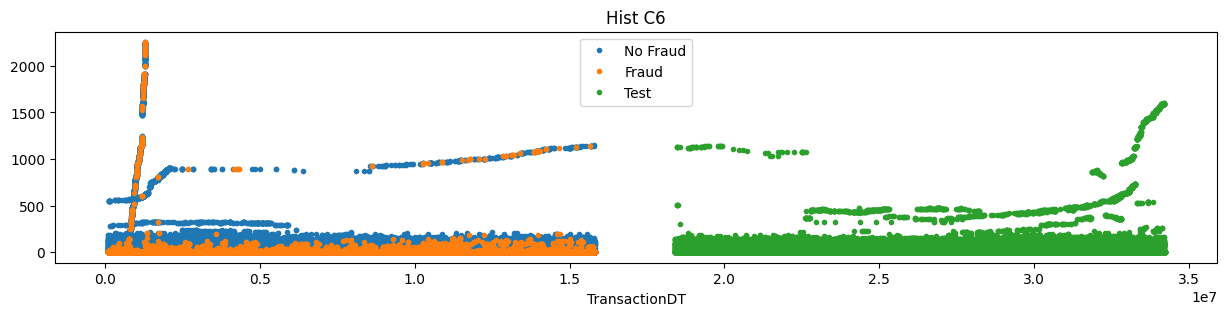

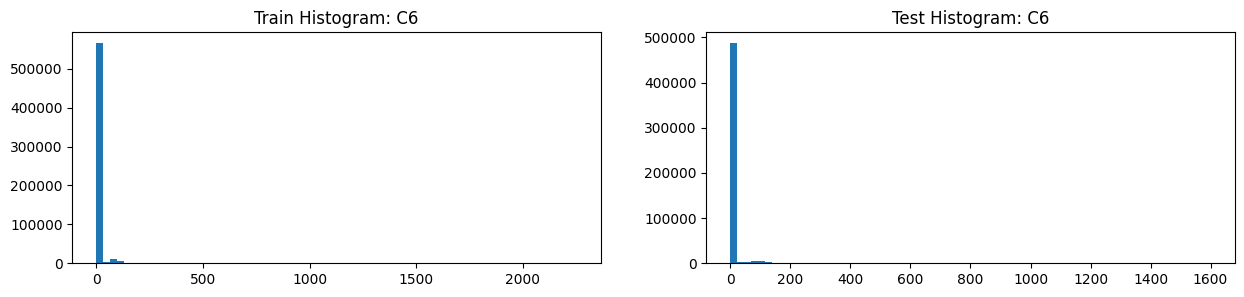

C6          Train             C6   Train Fraud             C6  \
0           count  590540.000000          count  20663.000000          count   
1            mean       9.071082           mean     16.923148           mean   
2             std      71.508467            std    126.298758            std   
3             min       0.000000            min      0.000000            min   
4             25%       1.000000            25%      1.000000            25%   
5             50%       1.000000            50%      1.000000            50%   
6             75%       2.000000            75%      3.000000            75%   
7             max    2253.000000            max   2251.000000            max   
8   unique values    1328.000000  unique values    282.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud             C6           Test             C6  \
0     569877.000000          count  506688.000000          count   
1          8.786377           mean       6.854992           mean   
2         68.689176            std      46.783565            std   
3          0.000000            min       0.000000            min   
4          1.000000            25%       1.000000            25%   
5          1.000000            50%       1.000000            50%   
6          2.000000            75%       2.000000            75%   
7       2253.000000            max    1601.000000            max   
8       1270.000000  unique values     834.000000  unique values   
9          0.000000           NaNs       3.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public             C6   Test Private  
0   101338.000000          count  405350.000000  
1        5.905988           mean       7.092244  
2       29.791409            std      50.136998  
3        0.000000            min       0.000000  
4        1.000000            25%       1.000000  
5        1.000000            50%       1.000000  
6        2.000000            75%       2.000000  
7     1138.000000            max    1601.000000  
8      201.000000  unique values     819.000000  
9        0.000000           NaNs       3.000000  
10       0.000000     NaNs share       0.000000

C6  Train Count  Mean Fraud  Fraud Count  Test Count
1  1.0       341552    0.027764         9483    289685.0
2  2.0        86103    0.037850         3259     75316.0
0  0.0        49066    0.031305         1536     45707.0
3  3.0        35490    0.042575         1511     31815.0
4  4.0        17805    0.053300          949     16420.0
5  5.0        10187    0.059880          610      8914.0
6  6.0         6048    0.078042          472      5293.0
7  7.0         3934    0.054652          215      3366.0
8  8.0         3048    0.057415          175      2105.0
9  9.0         2335    0.098073          229      1563.0

C6    size      mean   sum  TransactionID
0   1.0  341552  0.027764  9483         289685
1   2.0   86103  0.037850  3259          75316
2   0.0   49066  0.031305  1536          45707
3   3.0   35490  0.042575  1511          31815
4   4.0   17805  0.053300   949          16420
5   5.0   10187  0.059880   610           8914
6   6.0    6048  0.078042   472           5293
7  10.0    1817  0.128233   233           1267
8   9.0    2335  0.098073   229           1563
9   7.0    3934  0.054652   215           3366

Column  Correlation with C6
17      C6             1.000000
22     C11             0.991105
25     C14             0.984201
12      C1             0.982238
13      C2             0.974845
15      C4             0.962319
115    V75            -0.050655
75     V35            -0.052205
76     V36            -0.052338
237   V197            -0.058367
234   V194            -0.070188

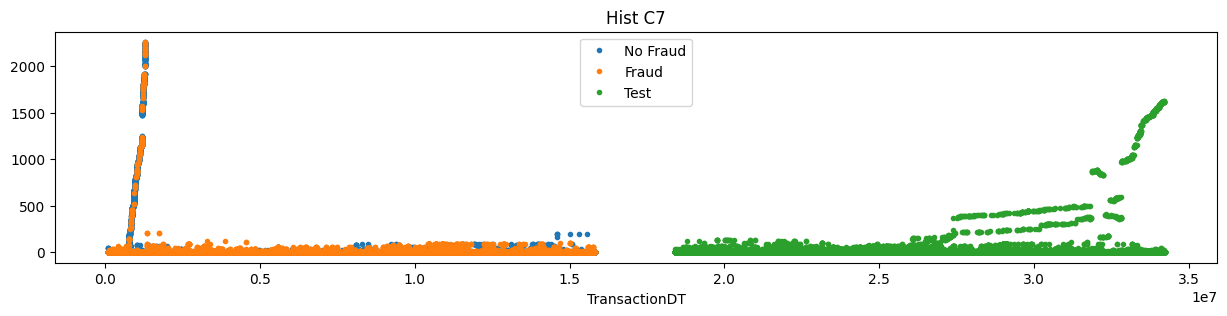

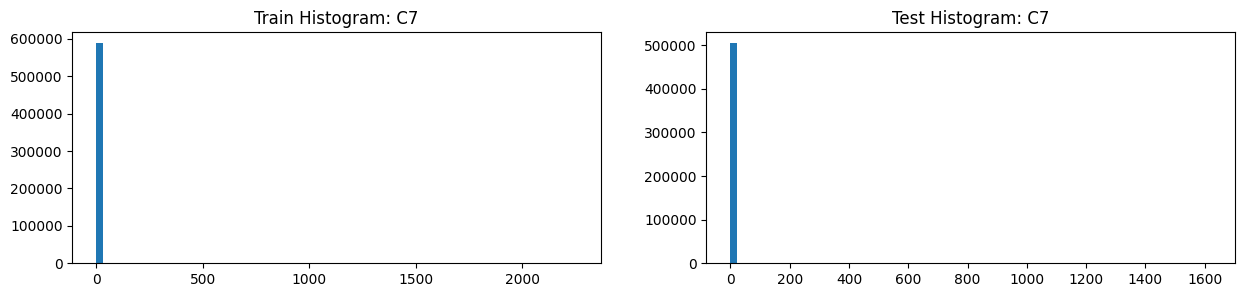

C7          Train             C7   Train Fraud             C7  \
0           count  590540.000000          count  20663.000000          count   
1            mean       2.848478           mean     11.977157           mean   
2             std      61.727304            std    115.143177            std   
3             min       0.000000            min      0.000000            min   
4             25%       0.000000            25%      0.000000            25%   
5             50%       0.000000            50%      0.000000            50%   
6             75%       0.000000            75%      1.000000            75%   
7             max    2255.000000            max   2253.000000            max   
8   unique values    1103.000000  unique values    197.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud             C7           Test             C7  \
0     569877.000000          count  506688.000000          count   
1          2.517484           mean       1.678173           mean   
2         58.860773            std      37.874827            std   
3          0.000000            min       0.000000            min   
4          0.000000            25%       0.000000            25%   
5          0.000000            50%       0.000000            50%   
6          0.000000            75%       0.000000            75%   
7       2255.000000            max    1621.000000            max   
8       1018.000000  unique values     518.000000  unique values   
9          0.000000           NaNs       3.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public             C7   Test Private  
0   101338.000000          count  405350.000000  
1        0.378002           mean       2.003217  
2        3.769175            std      42.297173  
3        0.000000            min       0.000000  
4        0.000000            25%       0.000000  
5        0.000000            50%       0.000000  
6        0.000000            75%       0.000000  
7      130.000000            max    1621.000000  
8       74.000000  unique values     511.000000  
9        0.000000           NaNs       3.000000  
10       0.000000     NaNs share       0.000000

C7  Train Count  Mean Fraud  Fraud Count  Test Count
0    0.0       523142    0.024376        12752    438095.0
1    1.0        51966    0.067294         3497     50141.0
2    2.0         7314    0.141509         1035      8712.0
3    3.0         2033    0.232661          473      2734.0
4    4.0         1109    0.431019          478      1344.0
5    5.0          481    0.580042          279       691.0
6    6.0          409    0.491443          201       478.0
7    7.0          267    0.441948          118       369.0
9    9.0          233    0.626609          146       216.0
10  10.0          175    0.782857          137       199.0

C7    size      mean    sum  TransactionID
0   0.0  523142  0.024376  12752         438095
1   1.0   51966  0.067294   3497          50141
2   2.0    7314  0.141509   1035           8712
3   4.0    1109  0.431019    478           1344
4   3.0    2033  0.232661    473           2734
5   5.0     481  0.580042    279            691
6   6.0     409  0.491443    201            478
7   9.0     233  0.626609    146            216
8  10.0     175  0.782857    137            199
9   7.0     267  0.441948    118            369

Column  Correlation with C7
17             C7             1.000000
22            C12             0.999489
20            C10             0.985062
18             C8             0.982983
12             C2             0.938867
11             C1             0.926258
81            V54            -0.056192
62            V35            -0.056947
63            V36            -0.058191
0   TransactionID            -0.059485
9           addr2            -0.116193

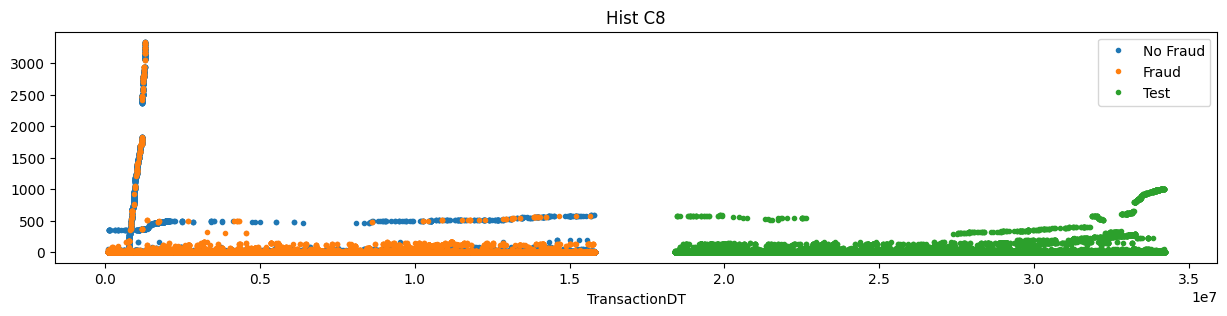

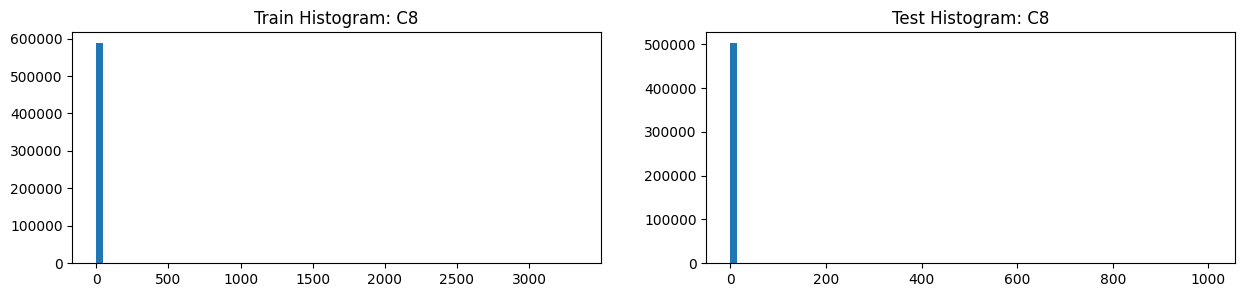

C8          Train             C8   Train Fraud             C8  \
0           count  590540.000000          count  20663.000000          count   
1            mean       5.144574           mean     21.242608           mean   
2             std      95.378574            std    176.695771            std   
3             min       0.000000            min      0.000000            min   
4             25%       0.000000            25%      0.000000            25%   
5             50%       0.000000            50%      1.000000            50%   
6             75%       0.000000            75%      2.000000            75%   
7             max    3331.000000            max   3328.000000            max   
8   unique values    1253.000000  unique values    311.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud             C8           Test             C8  \
0     569877.000000          count  506688.000000          count   
1          4.560881           mean       1.893994           mean   
2         91.023016            std      26.766115            std   
3          0.000000            min       0.000000            min   
4          0.000000            25%       0.000000            25%   
5          0.000000            50%       0.000000            50%   
6          0.000000            75%       1.000000            75%   
7       3331.000000            max    1005.000000            max   
8       1115.000000  unique values     442.000000  unique values   
9          0.000000           NaNs       3.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public             C8   Test Private  
0   101338.000000          count  405350.000000  
1        1.030157           mean       2.109954  
2       13.587651            std      29.140063  
3        0.000000            min       0.000000  
4        0.000000            25%       0.000000  
5        0.000000            50%       0.000000  
6        0.000000            75%       1.000000  
7      584.000000            max    1005.000000  
8      120.000000  unique values     421.000000  
9        0.000000           NaNs       3.000000  
10       0.000000     NaNs share       0.000000

C8  Train Count  Mean Fraud  Fraud Count  Test Count
0  0.0       447667    0.020899         9356    368637.0
1  1.0       104994    0.044393         4661     97332.0
2  2.0        15927    0.097633         1555     18261.0
3  3.0         5493    0.137266          754      6801.0
4  4.0         2817    0.182464          514      3172.0
8  8.0         1790    0.112849          202       810.0
6  6.0         1774    0.204059          362      1386.0
5  5.0         1721    0.222545          383      2035.0
7  7.0          988    0.237854          235      1015.0
9  9.0          718    0.307799          221       660.0

C8    size      mean   sum  TransactionID
0  0.0  447667  0.020899  9356         368637
1  1.0  104994  0.044393  4661          97332
2  2.0   15927  0.097633  1555          18261
3  3.0    5493  0.137266   754           6801
4  4.0    2817  0.182464   514           3172
5  5.0    1721  0.222545   383           2035
6  6.0    1774  0.204059   362           1386
7  7.0     988  0.237854   235           1015
8  9.0     718  0.307799   221            660
9  8.0    1790  0.112849   202            810

Column  Correlation with C8
18             C8             1.000000
20            C10             0.996970
22            C12             0.983027
17             C7             0.982983
12             C2             0.975863
11             C1             0.967746
81            V54            -0.056765
62            V35            -0.057420
63            V36            -0.058675
9           addr2            -0.059482
0   TransactionID            -0.060490

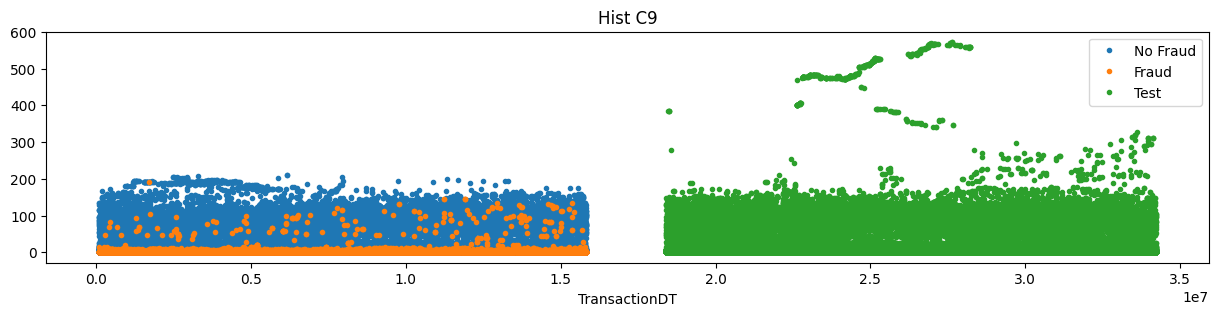

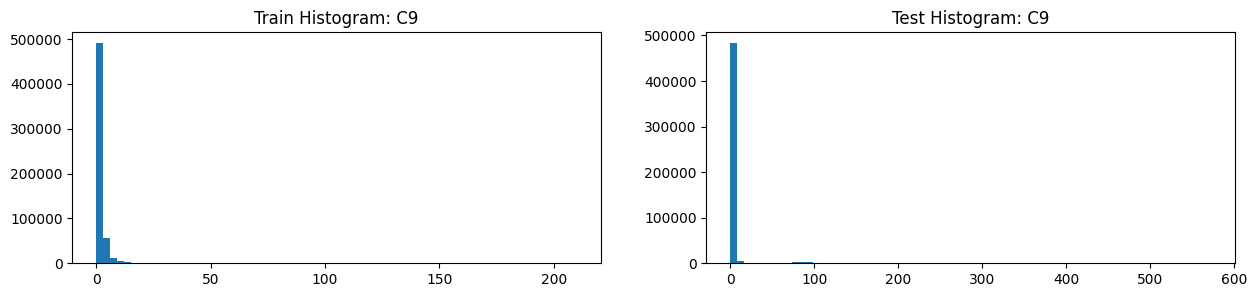

C9          Train             C9   Train Fraud             C9  \
0           count  590540.000000          count  20663.000000          count   
1            mean       4.480240           mean      1.703964           mean   
2             std      16.674897            std      8.453280            std   
3             min       0.000000            min      0.000000            min   
4             25%       0.000000            25%      0.000000            25%   
5             50%       1.000000            50%      0.000000            50%   
6             75%       2.000000            75%      1.000000            75%   
7             max     210.000000            max    192.000000            max   
8   unique values     205.000000  unique values    111.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud             C9           Test             C9  \
0     569877.000000          count  506688.000000          count   
1          4.580904           mean       4.611943           mean   
2         16.889451            std      21.282640            std   
3          0.000000            min       0.000000            min   
4          0.000000            25%       0.000000            25%   
5          1.000000            50%       1.000000            50%   
6          2.000000            75%       2.000000            75%   
7        210.000000            max     572.000000            max   
8        205.000000  unique values     354.000000  unique values   
9          0.000000           NaNs       3.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public             C9   Test Private  
0   101338.000000          count  405350.000000  
1        5.117676           mean       4.485509  
2       18.153380            std      21.993710  
3        0.000000            min       0.000000  
4        1.000000            25%       0.000000  
5        1.000000            50%       1.000000  
6        2.000000            75%       2.000000  
7      386.000000            max     572.000000  
8      175.000000  unique values     351.000000  
9        0.000000           NaNs       3.000000  
10       0.000000     NaNs share       0.000000

C9  Train Count  Mean Fraud  Fraud Count  Test Count
1  1.0       228938    0.019062         4364    191416.0
0  0.0       183795    0.066683        12256    157766.0
2  2.0        77829    0.021663         1686     68814.0
3  3.0        32505    0.026211          852     31510.0
4  4.0        16196    0.019820          321     15476.0
5  5.0         8648    0.034806          301      7835.0
6  6.0         5760    0.029514          170      4910.0
7  7.0         3529    0.026636           94      2970.0
8  8.0         2548    0.029827           76      2164.0
9  9.0         1871    0.078033          146      1480.0

C9    size      mean    sum  TransactionID
0  0.0  183795  0.066683  12256         157766
1  1.0  228938  0.019062   4364         191416
2  2.0   77829  0.021663   1686          68814
3  3.0   32505  0.026211    852          31510
4  4.0   16196  0.019820    321          15476
5  5.0    8648  0.034806    301           7835
6  6.0    5760  0.029514    170           4910
7  9.0    1871  0.078033    146           1480
8  7.0    3529  0.026636     94           2970
9  8.0    2548  0.029827     76           2164

Column  Correlation with C9
19      C9             1.000000
15      C5             0.925786
23     C13             0.704056
24     C14             0.397396
102    V70             0.266079
81     V49             0.264768
83     V51            -0.117889
194   V303            -0.121989
82     V50            -0.124945
195   V304            -0.134387
193   V302            -0.140374

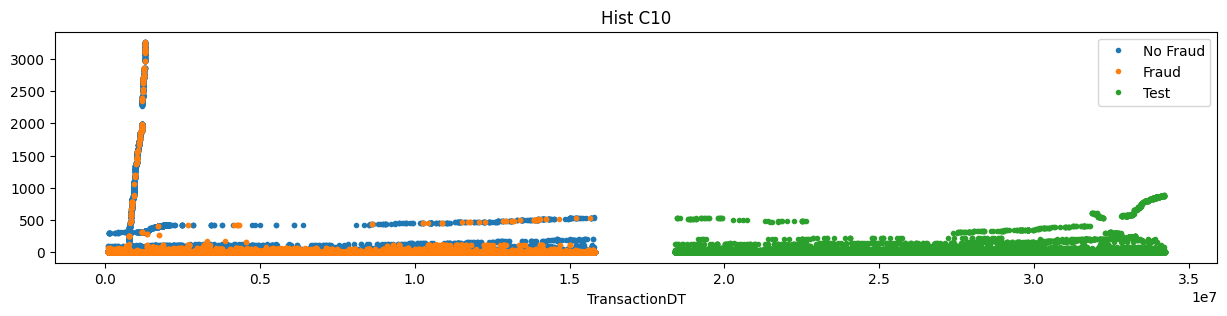

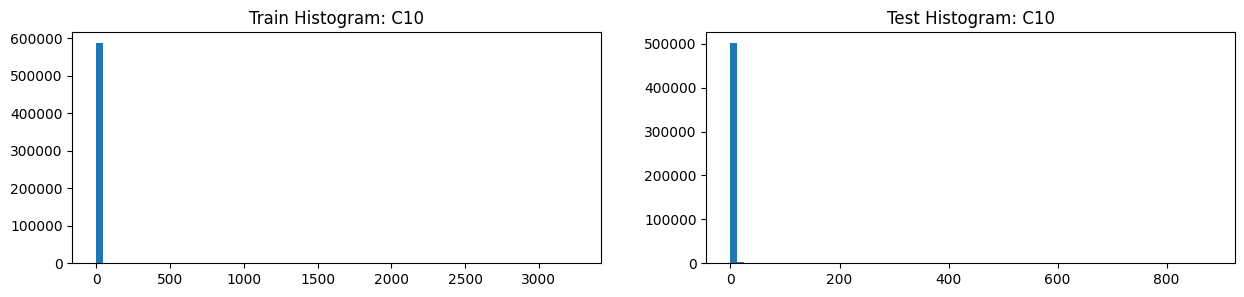

C10          Train            C10   Train Fraud            C10  \
0           count  590540.000000          count  20663.000000          count   
1            mean       5.240343           mean     19.493926           mean   
2             std      95.581443            std    176.919186            std   
3             min       0.000000            min      0.000000            min   
4             25%       0.000000            25%      0.000000            25%   
5             50%       0.000000            50%      1.000000            50%   
6             75%       0.000000            75%      2.000000            75%   
7             max    3257.000000            max   3254.000000            max   
8   unique values    1231.000000  unique values    234.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud            C10           Test            C10  \
0     569877.000000          count  506688.000000          count   
1          4.723526           mean       1.810149           mean   
2         91.239098            std      23.692393            std   
3          0.000000            min       0.000000            min   
4          0.000000            25%       0.000000            25%   
5          0.000000            50%       0.000000            50%   
6          0.000000            75%       1.000000            75%   
7       3257.000000            max     881.000000            max   
8       1163.000000  unique values     456.000000  unique values   
9          0.000000           NaNs       3.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public            C10   Test Private  
0   101338.000000          count  405350.000000  
1        0.869417           mean       2.045334  
2       11.906094            std      25.805962  
3        0.000000            min       0.000000  
4        0.000000            25%       0.000000  
5        0.000000            50%       0.000000  
6        0.000000            75%       1.000000  
7      530.000000            max     881.000000  
8      111.000000  unique values     438.000000  
9        0.000000           NaNs       3.000000  
10       0.000000     NaNs share       0.000000

C10  Train Count  Mean Fraud  Fraud Count  Test Count
0  0.0       453442    0.021273         9646    370978.0
1  1.0       100231    0.046303         4641     92343.0
2  2.0        14938    0.109452         1635     17752.0
3  3.0         6417    0.134175          861      6869.0
4  4.0         2836    0.197461          560      4002.0
5  5.0         1806    0.209856          379      2550.0
6  6.0         1286    0.209176          269      1858.0
7  7.0          817    0.250918          205      1235.0
8  8.0          627    0.280702          176       999.0
9  9.0          553    0.227848          126       782.0

C10    size      mean   sum  TransactionID
0   0.0  453442  0.021273  9646         370978
1   1.0  100231  0.046303  4641          92343
2   2.0   14938  0.109452  1635          17752
3   3.0    6417  0.134175   861           6869
4   4.0    2836  0.197461   560           4002
5   5.0    1806  0.209856   379           2550
6   6.0    1286  0.209176   269           1858
7   7.0     817  0.250918   205           1235
8   8.0     627  0.280702   176            999
9  10.0     420  0.373810   157            705

Column  Correlation with C10
20            C10              1.000000
18             C8              0.996970
17             C7              0.985062
22            C12              0.983817
12             C2              0.970624
11             C1              0.958202
2   TransactionDT             -0.057734
62            V35             -0.058026
63            V36             -0.059294
0   TransactionID             -0.062073
9           addr2             -0.068799

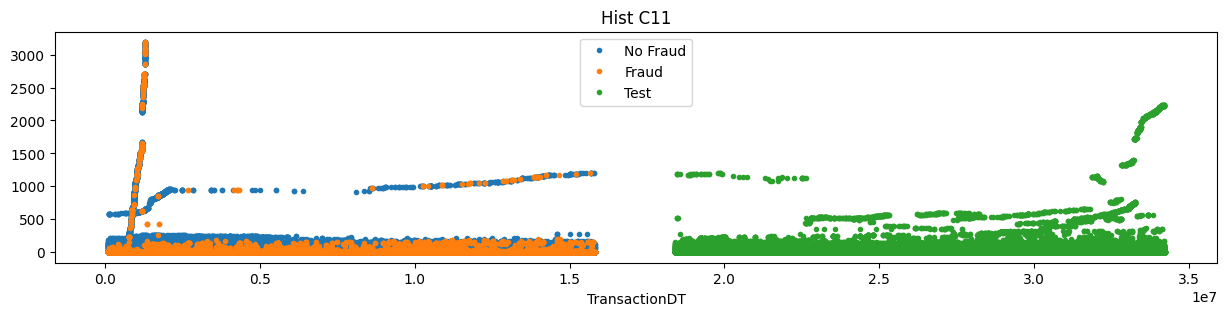

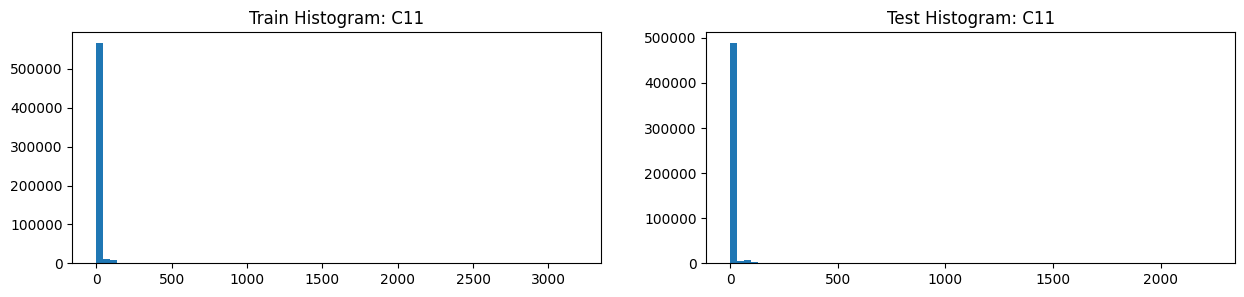

C11          Train            C11   Train Fraud            C11  \
0           count  590540.000000          count  20663.000000          count   
1            mean      10.241521           mean     23.857475           mean   
2             std      94.336292            std    170.966234            std   
3             min       0.000000            min      0.000000            min   
4             25%       1.000000            25%      1.000000            25%   
5             50%       1.000000            50%      2.000000            50%   
6             75%       2.000000            75%      4.000000            75%   
7             max    3188.000000            max   3186.000000            max   
8   unique values    1476.000000  unique values    330.000000  unique values   
9            NaNs       0.000000           NaNs      0.000000           NaNs   
10     NaNs share       0.000000     NaNs share      0.000000     NaNs share   

    Train Not Fraud            C11           Test            C11  \
0     569877.000000          count  506688.000000          count   
1          9.747825           mean       7.484594           mean   
2         90.306569            std      61.322505            std   
3          0.000000            min       0.000000            min   
4          1.000000            25%       1.000000            25%   
5          1.000000            50%       1.000000            50%   
6          2.000000            75%       2.000000            75%   
7       3188.000000            max    2234.000000            max   
8       1400.000000  unique values     937.000000  unique values   
9          0.000000           NaNs       3.000000           NaNs   
10         0.000000     NaNs share       0.000000     NaNs share   

      Test Public            C11   Test Private  
0   101338.000000          count  405350.000000  
1        6.042689           mean       7.845072  
2       31.478048            std      66.724831  
3        0.000000            min       0.000000  
4        1.000000            25%       1.000000  
5        1.000000            50%       1.000000  
6        2.000000            75%       2.000000  
7     1196.000000            max    2234.000000  
8      246.000000  unique values     912.000000  
9        0.000000           NaNs       3.000000  
10       0.000000     NaNs share       0.000000

C11  Train Count  Mean Fraud  Fraud Count  Test Count
1  1.0       389692    0.025346         9877    342100.0
2  2.0        89677    0.040378         3621     79103.0
3  3.0        34463    0.047181         1626     27179.0
4  4.0        16051    0.062675         1006     12427.0
5  5.0         9972    0.061472          613      6394.0
6  6.0         5966    0.070734          422      3686.0
7  7.0         3663    0.068523          251      2466.0
8  8.0         2892    0.079876          231      1799.0
0  0.0         1864    0.068133          127      4909.0
9  9.0         1805    0.077008          139      1147.0

C11    size      mean   sum  TransactionID
0   1.0  389692  0.025346  9877         342100
1   2.0   89677  0.040378  3621          79103
2   3.0   34463  0.047181  1626          27179
3   4.0   16051  0.062675  1006          12427
4   5.0    9972  0.061472   613           6394
5   6.0    5966  0.070734   422           3686
6   7.0    3663  0.068523   251           2466
7   8.0    2892  0.079876   231           1799
8  10.0    1634  0.091187   149            934
9   9.0    1805  0.077008   139           1147

Column  Correlation with C11
22             C11              1.000000
12              C1              0.996515
13              C2              0.993898
17              C6              0.991105
15              C4              0.974547
19              C8              0.962722
116            V76             -0.052040
0    TransactionID             -0.054122
75             V35             -0.054781
76             V36             -0.055351
234           V194             -0.055947

In [ ]:
warnings.filterwarnings("ignore")

# Constants
COLS_TO_SHOW = 150
CHUNK_SIZE = 100000  # Define an appropriate chunk size

# HTML Display Helper
def h(content):
    display(HTML(content))

# Load Data Efficiently
def load_large_csv(file_path, chunk_size=CHUNK_SIZE):
    dfs = [chunk for chunk in pd.read_csv(file_path, chunksize=chunk_size)]
    return pd.concat(dfs, ignore_index=True)

# Load datasets
tr = load_large_csv('/content/dataset-folder/train_transaction.csv')
te = load_large_csv('/content/dataset-folder/test_transaction.csv')
trid = load_large_csv('/content/dataset-folder/train_identity.csv')
teid = load_large_csv('/content/dataset-folder/test_identity.csv')

# Column Selection
included_cols = tr.columns[:COLS_TO_SHOW].tolist()
split_on = {'TransactionID', 'card1', 'addr1', 'C1', 'D1', 'M1', 'V1'}

# Generate Column Links
def generate_links(cols):
    return ', '.join(
        [f"<li><a href='#c_{col}'>{col}</a></li>" if col in split_on else f"<a href='#c_{col}'>{col}</a>" for col in cols]
    )

# Display Data Information
h(f'<b>Links to column info:</b> {generate_links(included_cols)}')
h(f'Train transactions shape: <b>{tr.shape}</b>, identity <b>{trid.shape}</b>'
  f'<br>Test transactions shape: <b>{te.shape}</b>, identity <b>{teid.shape}</b>')
h('Train transactions preview:')
display(tr.head(10))

# Time Histogram
def timehist1(col):
    N = 8000 if col == 'TransactionAmt' else np.inf
    plt.figure(figsize=(15, 3))
    tr[tr['isFraud'] == 0].set_index('TransactionDT')[col].clip(0, N).plot(style='.', title=f'Hist {col}')
    tr[tr['isFraud'] == 1].set_index('TransactionDT')[col].clip(0, N).plot(style='.')
    te.set_index('TransactionDT')[col].clip(0, N).plot(style='.')
    plt.legend(['No Fraud', 'Fraud', 'Test'])
    plt.show()

# Column Statistics
def describe_column(data, col, label):
    desc = data.describe().reset_index()
    desc.columns = [col, label]
    extra_stats = pd.DataFrame({
        col: ['unique values', 'NaNs', 'NaNs share'],
        label: [data.nunique(), data.isnull().sum(), round(data.isnull().mean(), 4)]
    })
    return pd.concat([desc, extra_stats], ignore_index=True)

# Detailed Description
def desc1(col):
    summary = [
        describe_column(tr[col], col, 'Train'),
        describe_column(tr[tr['isFraud'] == 1][col], col, 'Train Fraud'),
        describe_column(tr[tr['isFraud'] == 0][col], col, 'Train Not Fraud'),
        describe_column(te[col], col, 'Test')
    ]

    n_public = int(te.shape[0] * 0.2)
    summary.append(describe_column(te.iloc[:n_public][col], col, 'Test Public'))
    summary.append(describe_column(te.iloc[n_public:][col], col, 'Test Private'))

    display(pd.concat(summary, axis=1))

    if col != 'TransactionID':
        h('<b>Most popular values (NaN = -999):</b>')
        tr_filled = tr[['isFraud', col]].fillna(-999)
        te_filled = te[['TransactionID', col]].fillna(-999)

        freq_train = tr_filled.groupby(col)['isFraud'].agg(['size', 'mean', 'sum']).reset_index()
        freq_test = te_filled.groupby(col)['TransactionID'].count().reset_index()

        summary_table = freq_train.merge(freq_test, how='left', on=col).rename(
            columns={'size': 'Train Count', 'mean': 'Mean Fraud', 'sum': 'Fraud Count', 'TransactionID': 'Test Count'}
        ).nlargest(10, 'Train Count')
        display(summary_table)

        h('<b>Biggest fraud sum values in train (NaN = -999):</b>')
        fraud_summary = freq_train.nlargest(10, 'sum').merge(freq_test, how='left', on=col)
        display(fraud_summary)

# Histograms
def hist1(col):
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    axes[0].hist(tr[col].dropna(), bins=70)
    axes[0].set_title(f'Train Histogram: {col}')
    axes[1].hist(te[col].dropna(), bins=70)
    axes[1].set_title(f'Test Histogram: {col}')
    plt.show()

# Correlation Analysis
def corr1(col):
    num_vars = tr.select_dtypes(include=[np.number]).columns.tolist()
    corrs = tr[num_vars].corrwith(tr[col]).dropna().reset_index()
    corrs.columns = ['Column', f'Correlation with {col}']
    corrs = corrs.sort_values(by=f'Correlation with {col}', ascending=False)

    h(f'<b>Most correlated values with {col}:</b>')
    # Use pd.concat instead of append
    display(pd.concat([corrs.head(6), corrs.tail(5)]))

# Column Analysis
def analyze_column(col):
    if col not in {'isFraud', 'TransactionDT'}:
        h(f'<h3 id="c_{col}">{col}</h3><a style="font-size:11px" href="#home">(Jump to top)</a>')
        if tr[col].dtype == 'object':
            desc1(col)
        else:
            timehist1(col)
            hist1(col)
            desc1(col)
            corr1(col)

# Apply analysis to all included columns
for col in included_cols:
    analyze_column(col)


In [ ]:
#Checked fro duplicates and found 0 hence not running this cell again as it is consuming huge amount of RAM
#print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


In [ ]:
# Summary of categorical features
df.describe(include="O")


ProductCD   card4   card6 P_emaildomain R_emaildomain      M1      M2  \
count     590540  588963  588969        496084        137291  319440  319440   
unique         5       4       4            59            60       2       2   
top            W    visa   debit     gmail.com     gmail.com       T       T   
freq      439670  384767  439938        228355         57147  319415  285468   

            M3      M4      M5      M6      M7      M8      M9  
count   319440  309096  240058  421180  244275  244288  244288  
unique       2       3       2       2       2       2       2  
top          T      M0       F       F       F       F       T  
freq    251731  196405  132491  227856  211374  155251  205656

In [ ]:
df.describe()

TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.000000   
mean     9898.734658     362.555488     153.194925     199.278897   
std      4901.170153     157.793246      11.336444      41.244453   
min      1000.000000     100.000000     100.000000     100.000000   
25%      6019.000000     214.000000     150.000000     166.000000   
50%      9678.000000     361.000000     150.000000     226.000000   
75%     14184.000000     512.000000     150.000000     226.000000   
max     18396.000000     600.000000     231.000000     237.000000   

               addr1          addr2  ...          V330           V331  \
count  524834.000000  524834.000000  ...  82351.000000   82351.000000   
mean      290.733794      86.800630  ...      0.775874     721.741883   
std       101.741072       2.690623  ...      4.727971    6217.223583   
min       100.000000      10.000000  ...      0.000000       0.000000   
25%       204.000000      87.000000  ...      0.000000       0.000000   
50%       299.000000      87.000000  ...      0.000000       0.000000   
75%       330.000000      87.000000  ...      0.000000       0.000000   
max       540.000000     102.000000  ...     55.000000  160000.000000   

                V332           V333          V334         V335          V336  \
count   82351.000000   82351.000000  82351.000000  82351.00000  82351.000000   
mean     1375.783644    1014.622782      9.807015     59.16455     28.530903   
std     11169.275702    7955.735482    243.861391    387.62948    274.576920   
min         0.000000       0.000000      0.000000      0.00000      0.000000   
25%         0.000000       0.000000      0.000000      0.00000      0.000000   
50%         0.000000       0.000000      0.000000      0.00000      0.000000   
75%        25.000000       0.000000      0.000000      0.00000      0.000000   
max    160000.000000  160000.000000  55125.000000  55125.00000  55125.000000   

                V337           V338           V339  
count   82351.000000   82351.000000   82351.000000  
mean       55.352422     151.160542     100.700882  
std       668.486833    1095.034387     814.946722  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max    104060.000000  104060.000000  104060.000000  

[8 rows x 380 columns]

In [ ]:
categorical_cols = df.select_dtypes(include=["object"]).columns

for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


ProductCD: 5 unique values
card4: 4 unique values
card6: 4 unique values
P_emaildomain: 59 unique values
R_emaildomain: 60 unique values
M1: 2 unique values
M2: 2 unique values
M3: 2 unique values
M4: 3 unique values
M5: 2 unique values
M6: 2 unique values
M7: 2 unique values
M8: 2 unique values
M9: 2 unique values


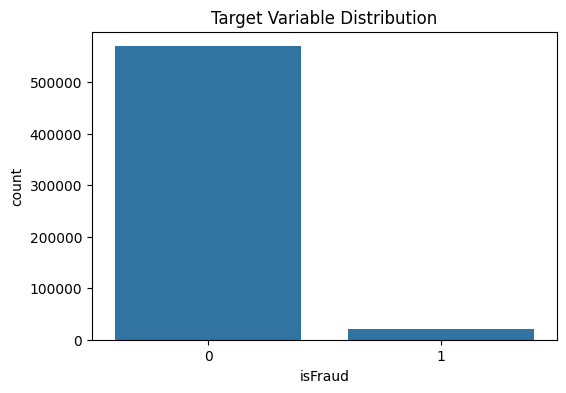

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check target column distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["isFraud"])  # Replace with actual target column
plt.title("Target Variable Distribution")
plt.show()


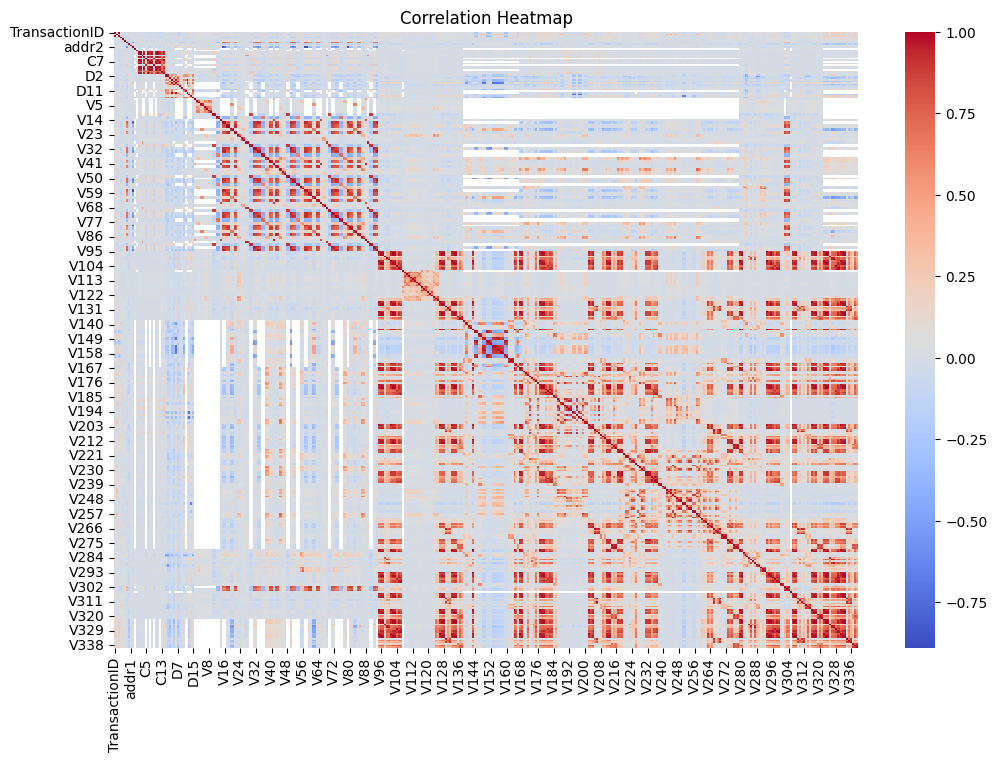

In [ ]:
import numpy as np

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

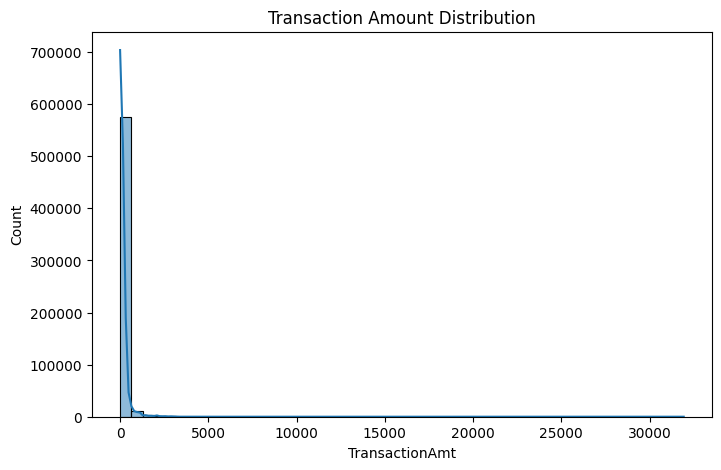

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df["TransactionAmt"], bins=50, kde=True)  # Replace with actual column name
plt.title("Transaction Amount Distribution")
plt.show()
